# 檢視與處理 Outliers
### 為何會有 outliers, 常見的 outlier 原因
* 未知值，隨意填補 (約定俗成的代入)，如年齡常見 0,999
* 可能的錯誤紀錄/手誤/系統性錯誤，如某本書在某筆訂單的銷售量 = 1000 本

# [作業目標]
- 依照下列提示與引導, 以幾種不同的方式, 檢視可能的離群值

# [作業重點]
- 從原始資料篩選可能的欄位, 看看那些欄位可能有離群值 (In[3], Out[3])
- 繪製目標值累積密度函數(ECDF)的圖形, 和常態分布的累積密度函數對比, 以確認是否有離群值的情形 (In[6], Out[6], In[7], Out[7])

In [110]:
# Import 需要的套件
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

# 設定 data_path
dir_data = './data'

In [111]:
f_app = os.path.join(dir_data, 'application_train.csv')
print('Path of read in data: %s' % (f_app))
app_train = pd.read_csv(f_app)
app_train.head()

Path of read in data: ./data\application_train.csv


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


## 請參考 HomeCredit_columns_description.csv 的欄位說明，觀察並列出三個你覺得可能有 outlier 的欄位並解釋可能的原因

### 先篩選出數值型的特徵欄位

In [112]:
## 先篩選出數值型的特徵欄位
dtype_select = [np.dtype('int64'), np.dtype('float64')]
## 檢視特徵是否符合數值型
print(app_train.dtypes.isin(dtype_select))
## 過濾出所有為數值型的特徵
numeric_columns = list(app_train.columns[list(app_train.dtypes.isin(dtype_select))])
numeric_columns

SK_ID_CURR                     True
TARGET                         True
NAME_CONTRACT_TYPE            False
CODE_GENDER                   False
FLAG_OWN_CAR                  False
                              ...  
AMT_REQ_CREDIT_BUREAU_DAY      True
AMT_REQ_CREDIT_BUREAU_WEEK     True
AMT_REQ_CREDIT_BUREAU_MON      True
AMT_REQ_CREDIT_BUREAU_QRT      True
AMT_REQ_CREDIT_BUREAU_YEAR     True
Length: 122, dtype: bool


['SK_ID_CURR',
 'TARGET',
 'CNT_CHILDREN',
 'AMT_INCOME_TOTAL',
 'AMT_CREDIT',
 'AMT_ANNUITY',
 'AMT_GOODS_PRICE',
 'REGION_POPULATION_RELATIVE',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'DAYS_REGISTRATION',
 'DAYS_ID_PUBLISH',
 'OWN_CAR_AGE',
 'FLAG_MOBIL',
 'FLAG_EMP_PHONE',
 'FLAG_WORK_PHONE',
 'FLAG_CONT_MOBILE',
 'FLAG_PHONE',
 'FLAG_EMAIL',
 'CNT_FAM_MEMBERS',
 'REGION_RATING_CLIENT',
 'REGION_RATING_CLIENT_W_CITY',
 'HOUR_APPR_PROCESS_START',
 'REG_REGION_NOT_LIVE_REGION',
 'REG_REGION_NOT_WORK_REGION',
 'LIVE_REGION_NOT_WORK_REGION',
 'REG_CITY_NOT_LIVE_CITY',
 'REG_CITY_NOT_WORK_CITY',
 'LIVE_CITY_NOT_WORK_CITY',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'APARTMENTS_AVG',
 'BASEMENTAREA_AVG',
 'YEARS_BEGINEXPLUATATION_AVG',
 'YEARS_BUILD_AVG',
 'COMMONAREA_AVG',
 'ELEVATORS_AVG',
 'ENTRANCES_AVG',
 'FLOORSMAX_AVG',
 'FLOORSMIN_AVG',
 'LANDAREA_AVG',
 'LIVINGAPARTMENTS_AVG',
 'LIVINGAREA_AVG',
 'NONLIVINGAPARTMENTS_AVG',
 'NONLIVINGAREA_AVG',
 'APARTMENTS_MODE',
 'BASEMENTAR

### 把只有兩個唯一值(通常是 0, 1)的特徵欄位拿掉

In [113]:
## 把只有兩個唯一值(通常是 0, 1)的特徵欄位拿掉

## 列出數值型特徵中唯一值是否不等於2
filter_columns = app_train[numeric_columns].apply(lambda x: len(x.unique()) != 2)
print(filter_columns)
## 過濾出數值型特徵欄位中唯一值不等於2的特徵
numeric_columns = list(app_train[numeric_columns].columns[filter_columns])
numeric_columns

SK_ID_CURR                     True
TARGET                        False
CNT_CHILDREN                   True
AMT_INCOME_TOTAL               True
AMT_CREDIT                     True
                              ...  
AMT_REQ_CREDIT_BUREAU_DAY      True
AMT_REQ_CREDIT_BUREAU_WEEK     True
AMT_REQ_CREDIT_BUREAU_MON      True
AMT_REQ_CREDIT_BUREAU_QRT      True
AMT_REQ_CREDIT_BUREAU_YEAR     True
Length: 106, dtype: bool


['SK_ID_CURR',
 'CNT_CHILDREN',
 'AMT_INCOME_TOTAL',
 'AMT_CREDIT',
 'AMT_ANNUITY',
 'AMT_GOODS_PRICE',
 'REGION_POPULATION_RELATIVE',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'DAYS_REGISTRATION',
 'DAYS_ID_PUBLISH',
 'OWN_CAR_AGE',
 'CNT_FAM_MEMBERS',
 'REGION_RATING_CLIENT',
 'REGION_RATING_CLIENT_W_CITY',
 'HOUR_APPR_PROCESS_START',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'APARTMENTS_AVG',
 'BASEMENTAREA_AVG',
 'YEARS_BEGINEXPLUATATION_AVG',
 'YEARS_BUILD_AVG',
 'COMMONAREA_AVG',
 'ELEVATORS_AVG',
 'ENTRANCES_AVG',
 'FLOORSMAX_AVG',
 'FLOORSMIN_AVG',
 'LANDAREA_AVG',
 'LIVINGAPARTMENTS_AVG',
 'LIVINGAREA_AVG',
 'NONLIVINGAPARTMENTS_AVG',
 'NONLIVINGAREA_AVG',
 'APARTMENTS_MODE',
 'BASEMENTAREA_MODE',
 'YEARS_BEGINEXPLUATATION_MODE',
 'YEARS_BUILD_MODE',
 'COMMONAREA_MODE',
 'ELEVATORS_MODE',
 'ENTRANCES_MODE',
 'FLOORSMAX_MODE',
 'FLOORSMIN_MODE',
 'LANDAREA_MODE',
 'LIVINGAPARTMENTS_MODE',
 'LIVINGAREA_MODE',
 'NONLIVINGAPARTMENTS_MODE',
 'NONLIVINGAREA_MODE',
 'APARTMENTS_MED

### 視覺化 - 檢視這些特徵的數值範圍，使用Box Plot 箱型圖、Histogram圖

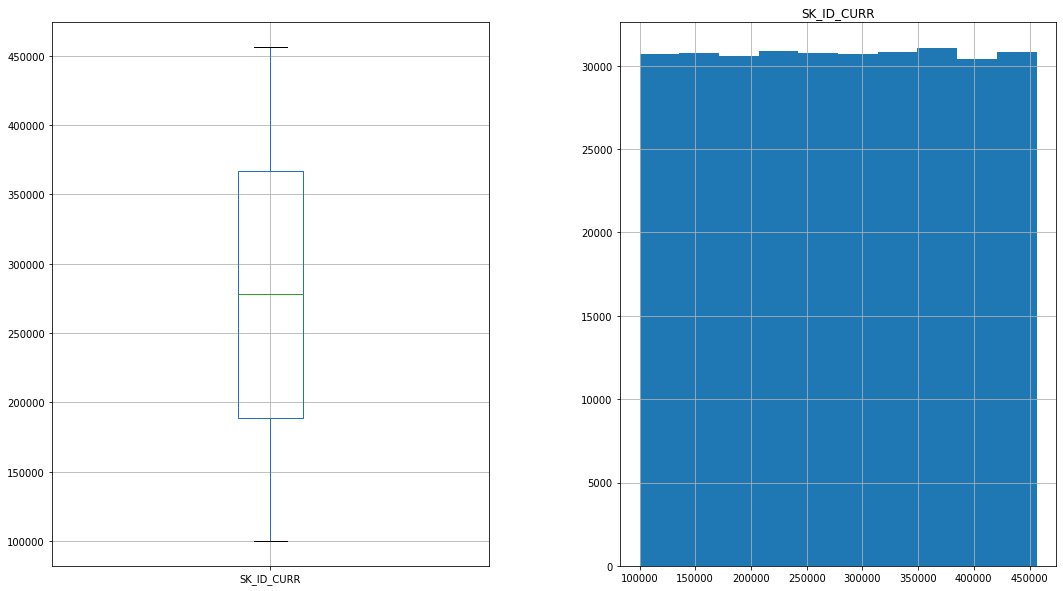

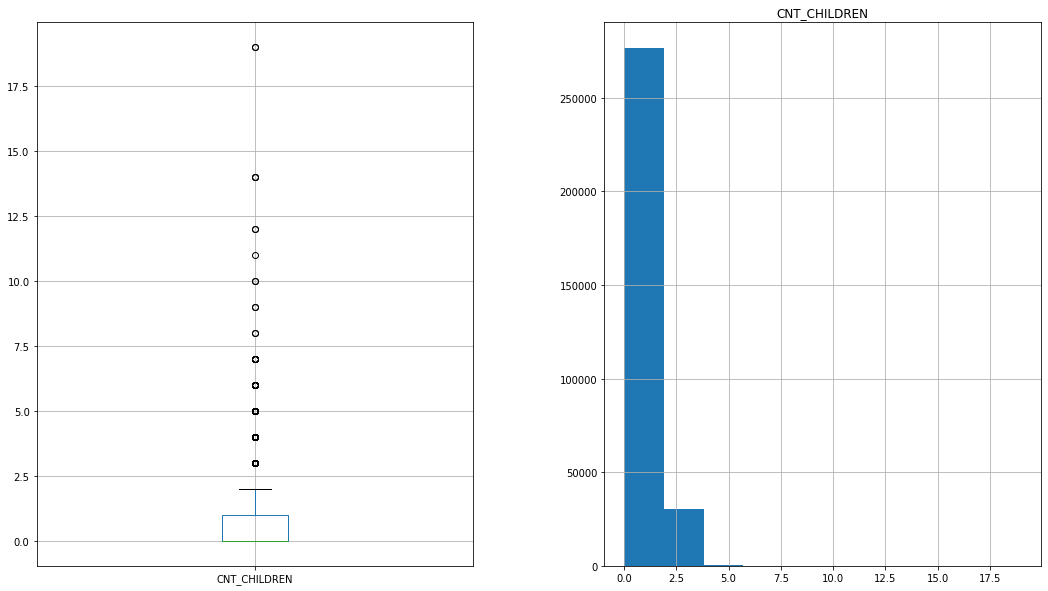

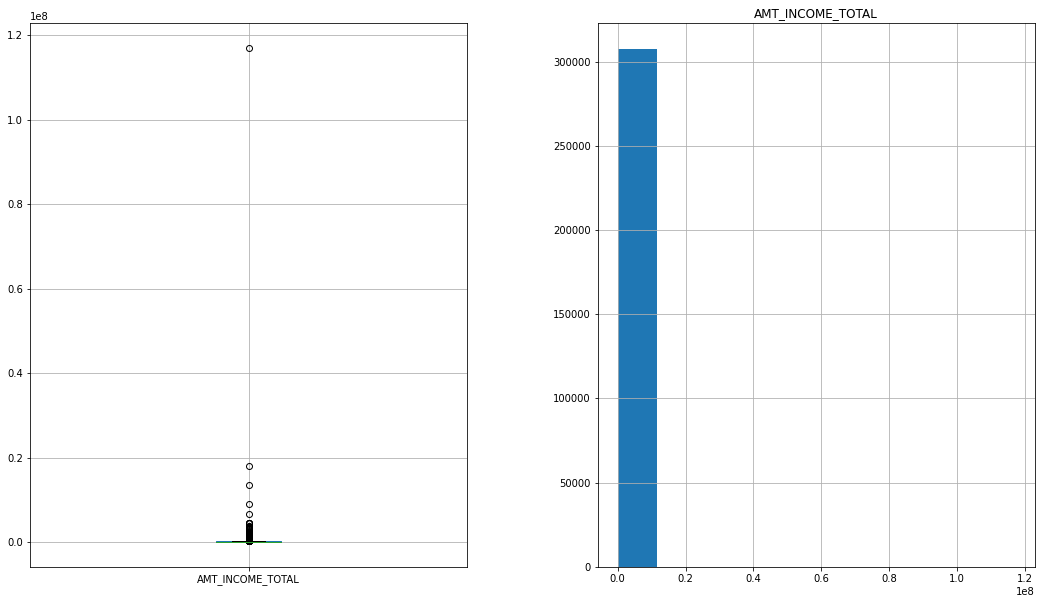

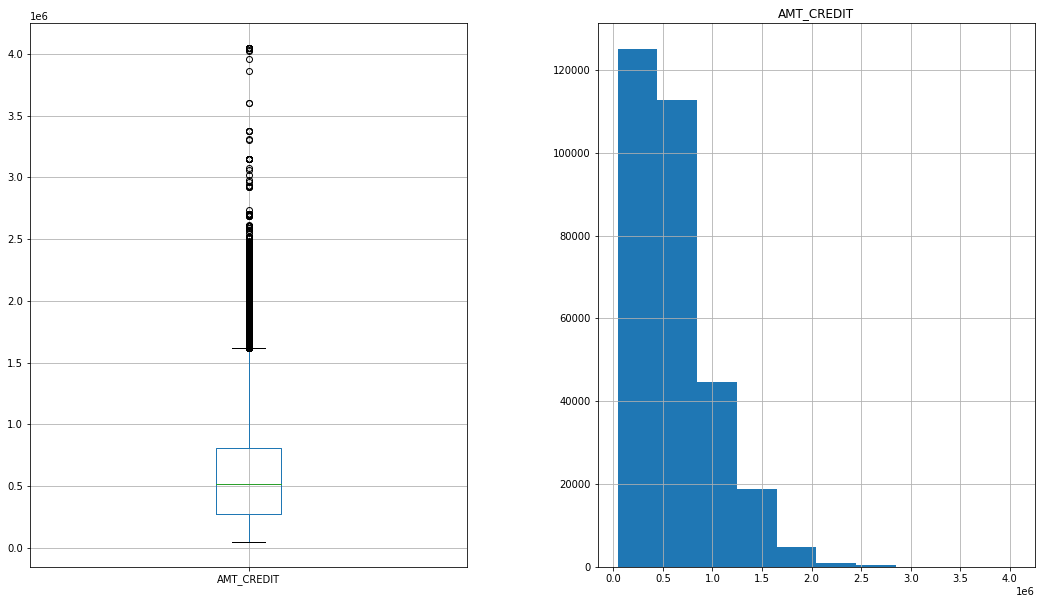

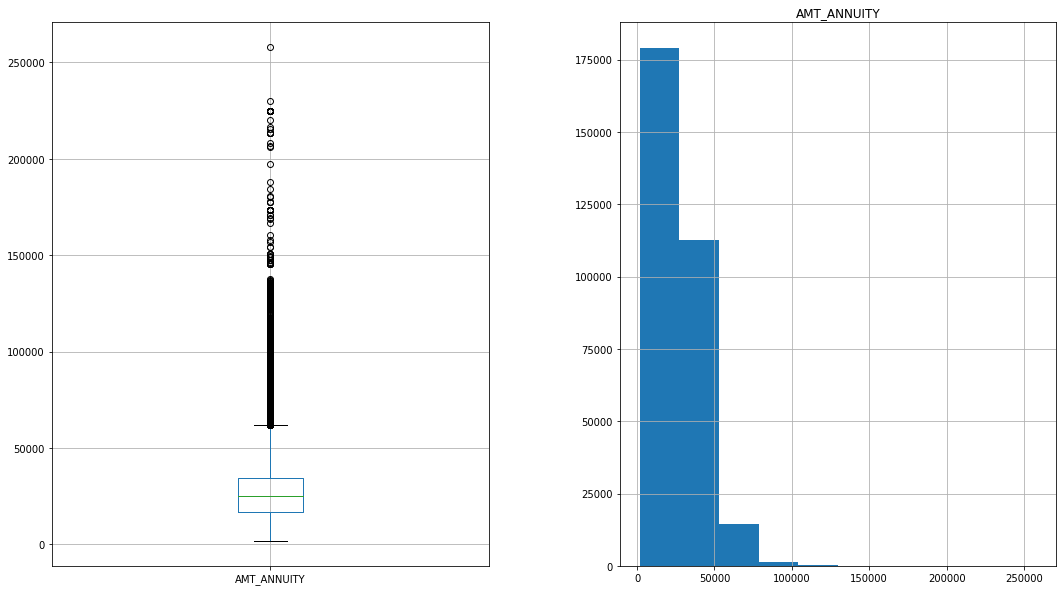

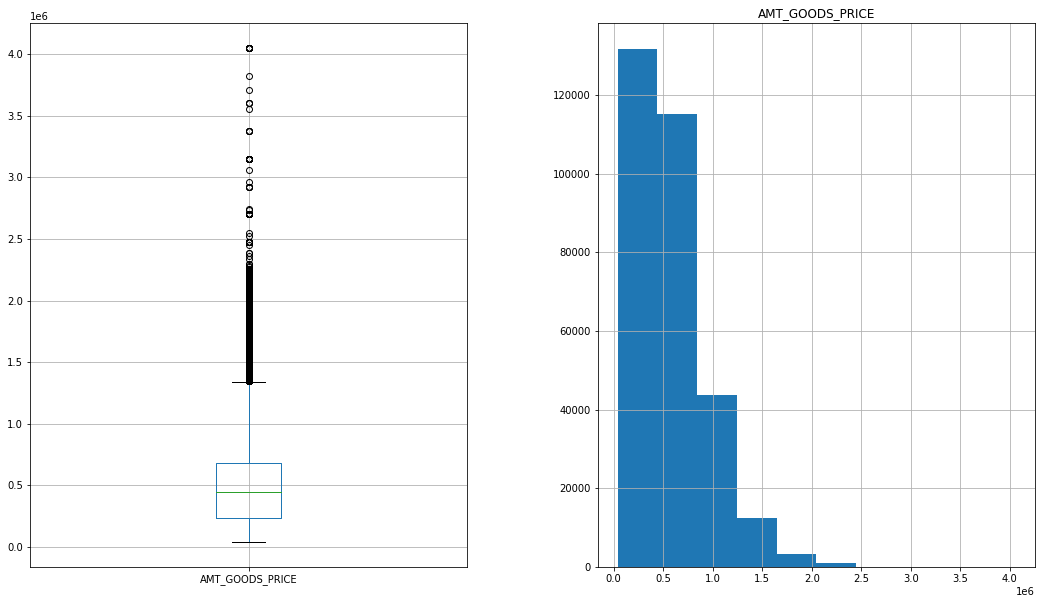

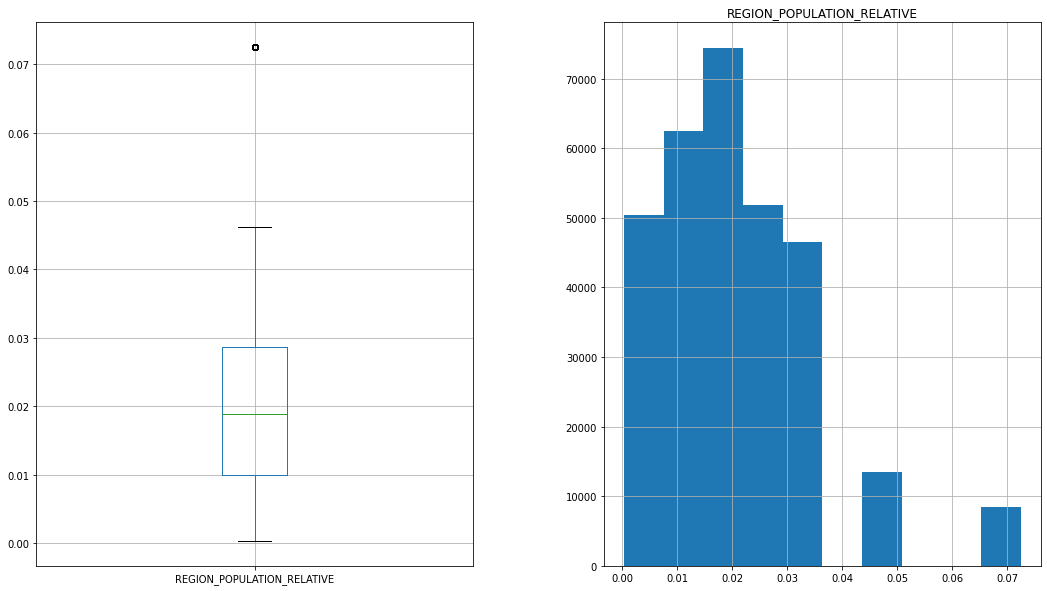

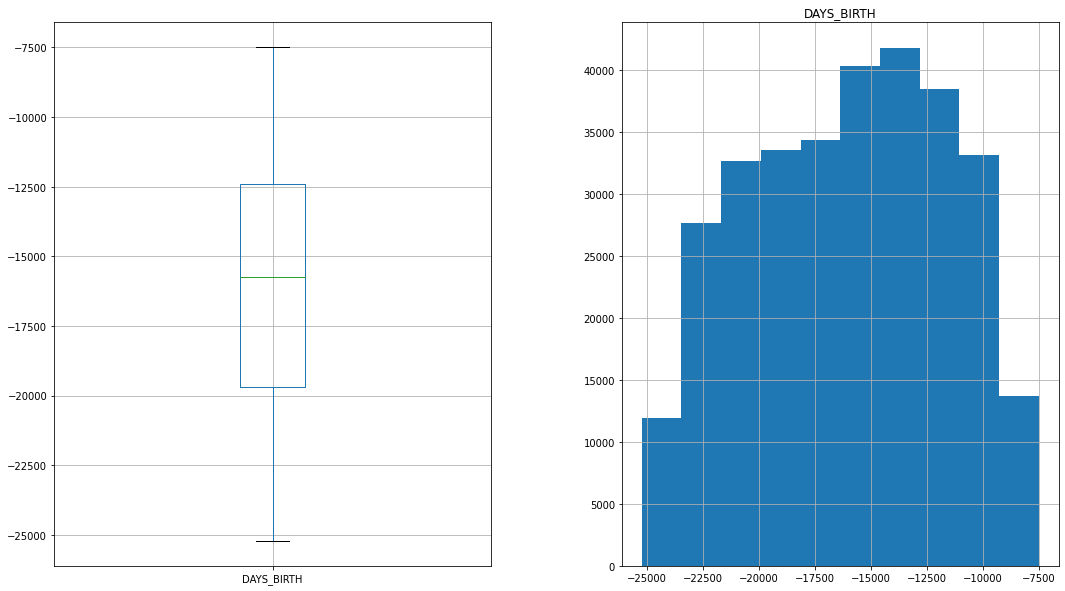

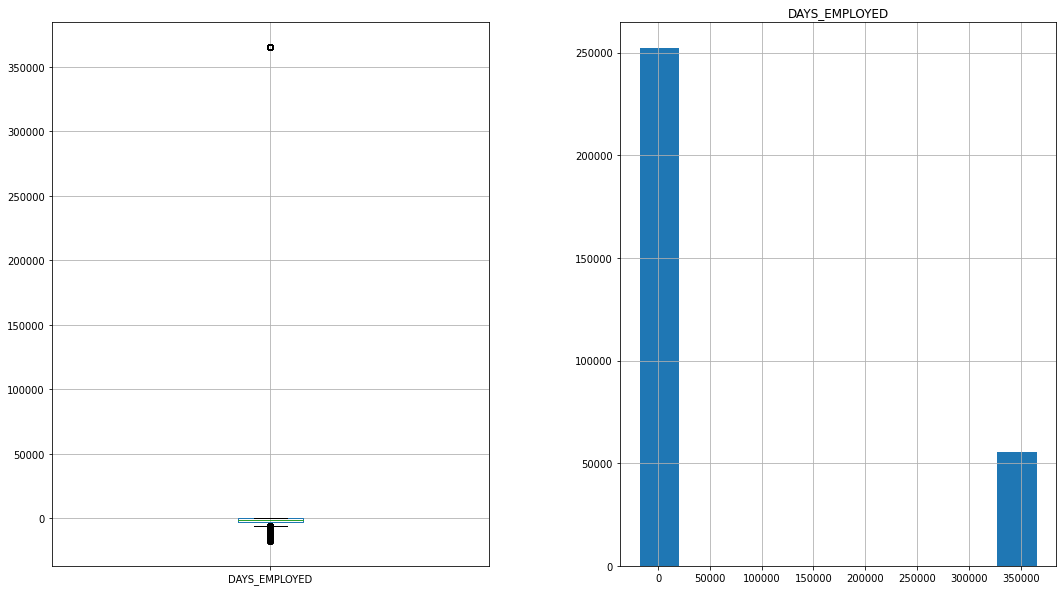

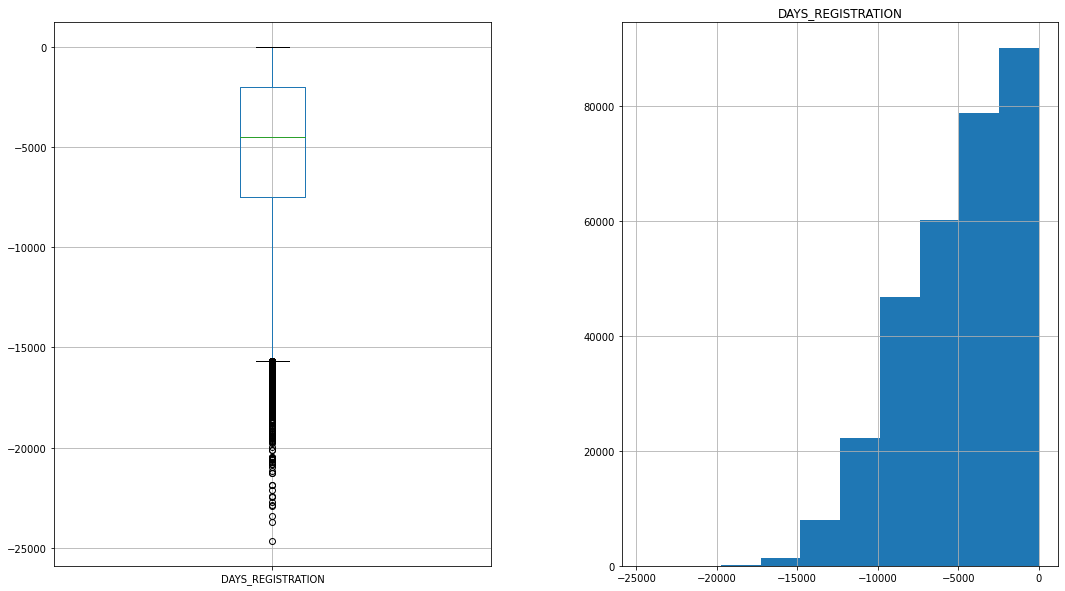

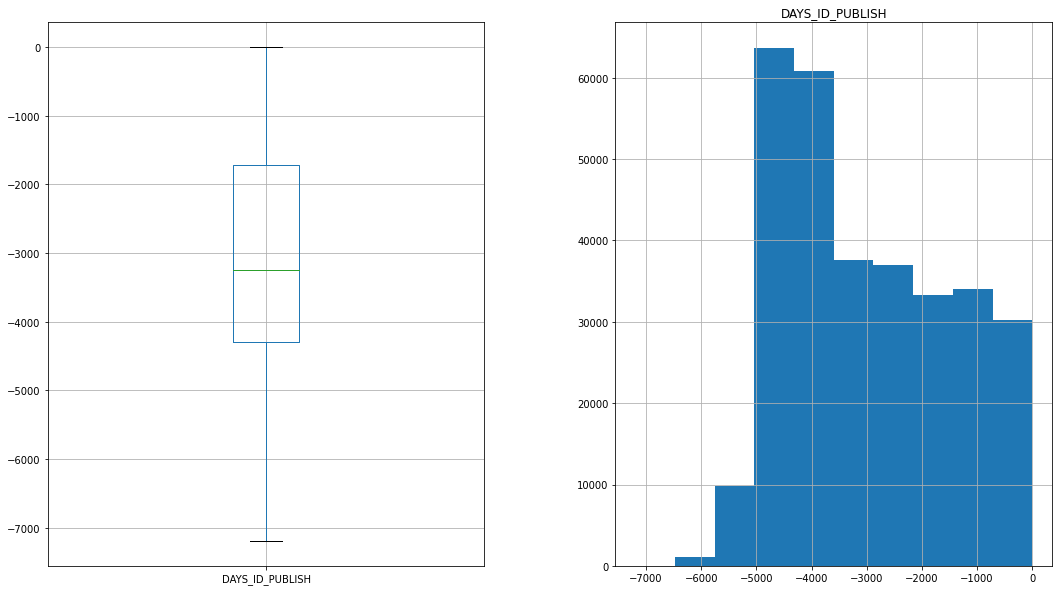

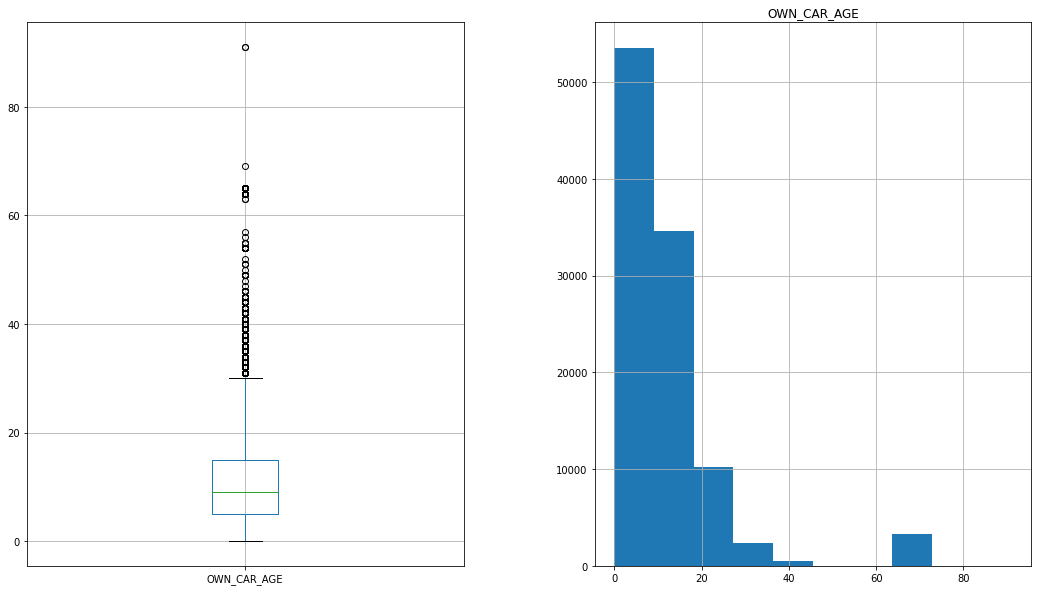

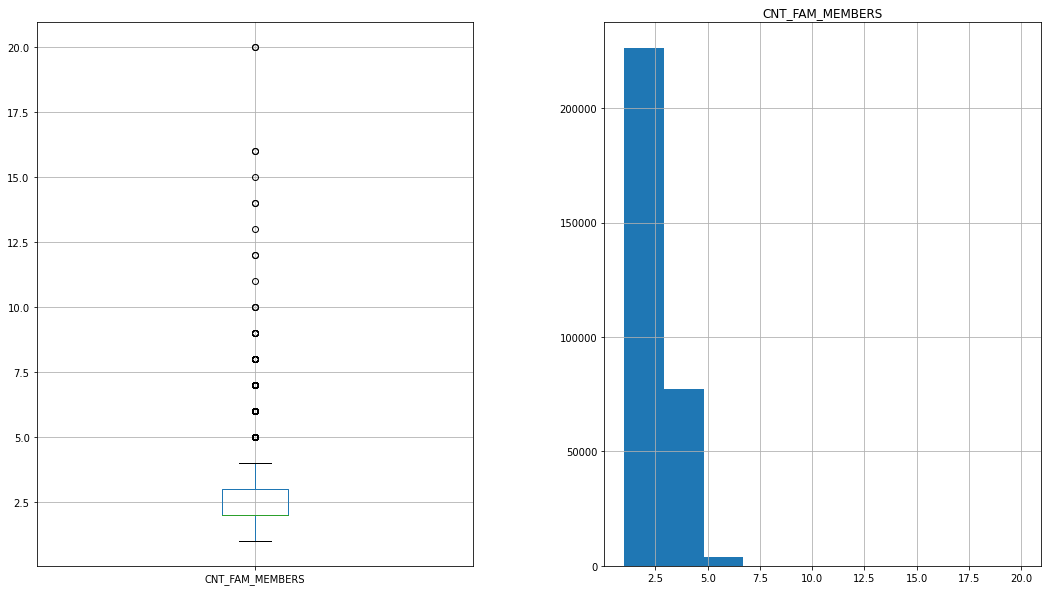

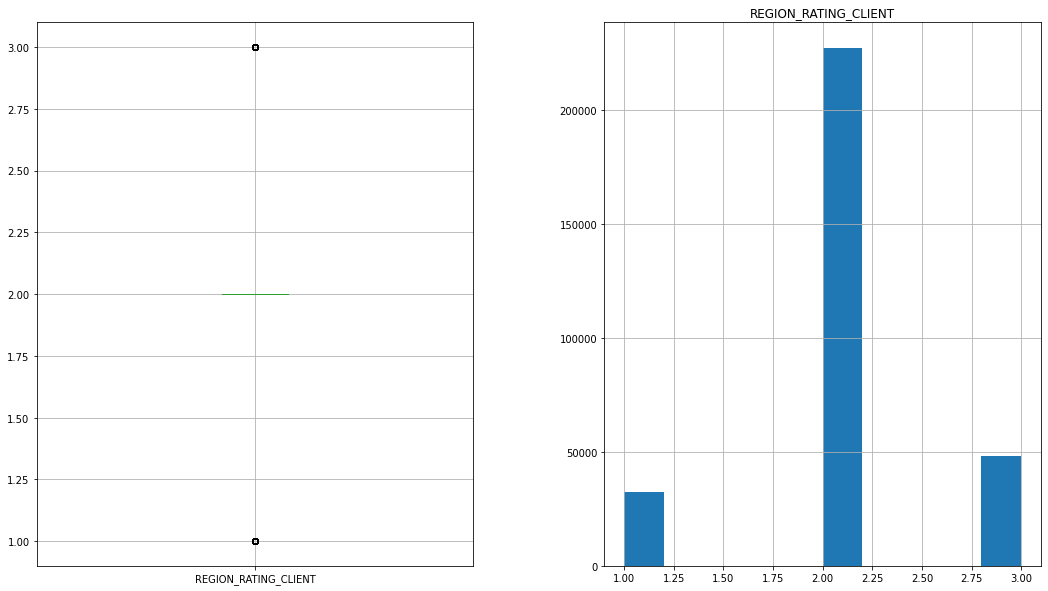

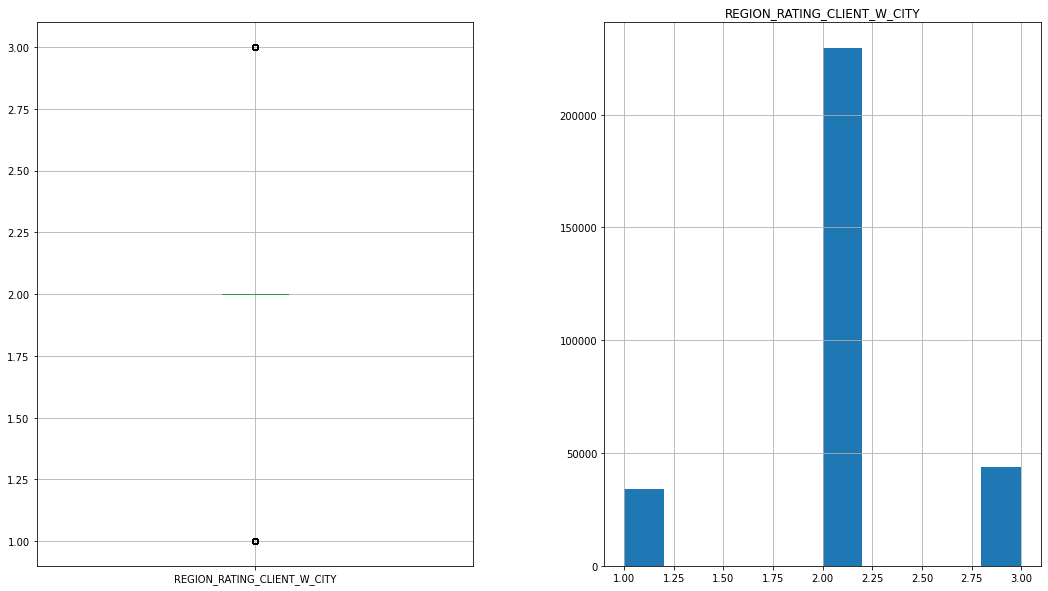

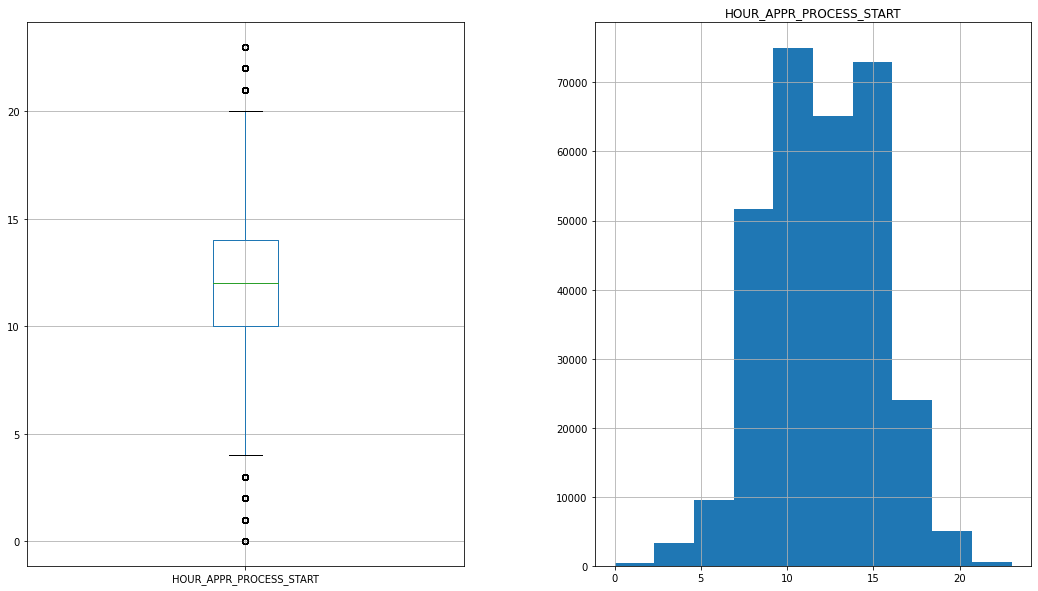

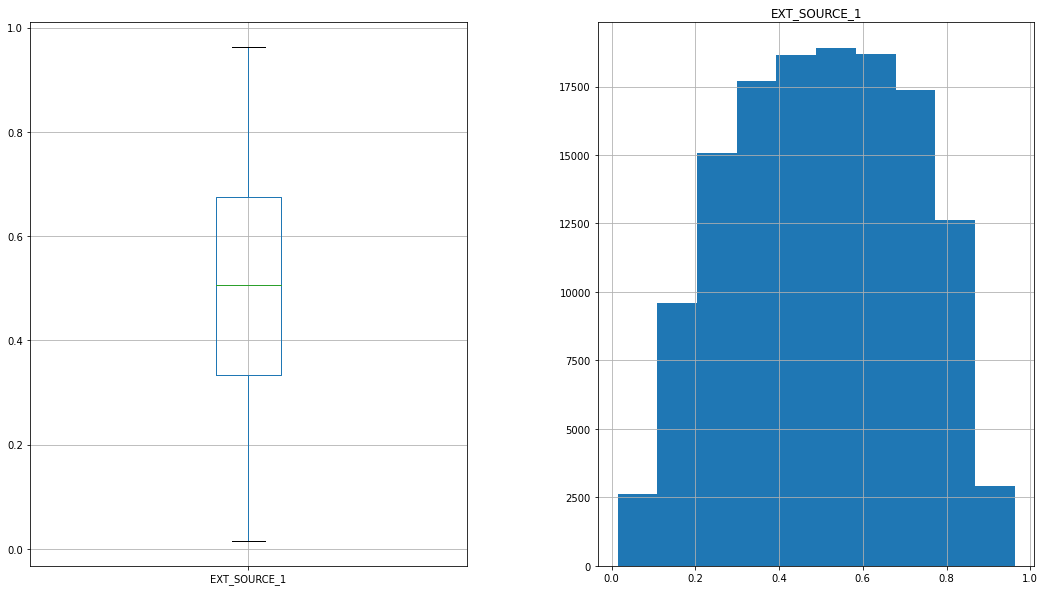

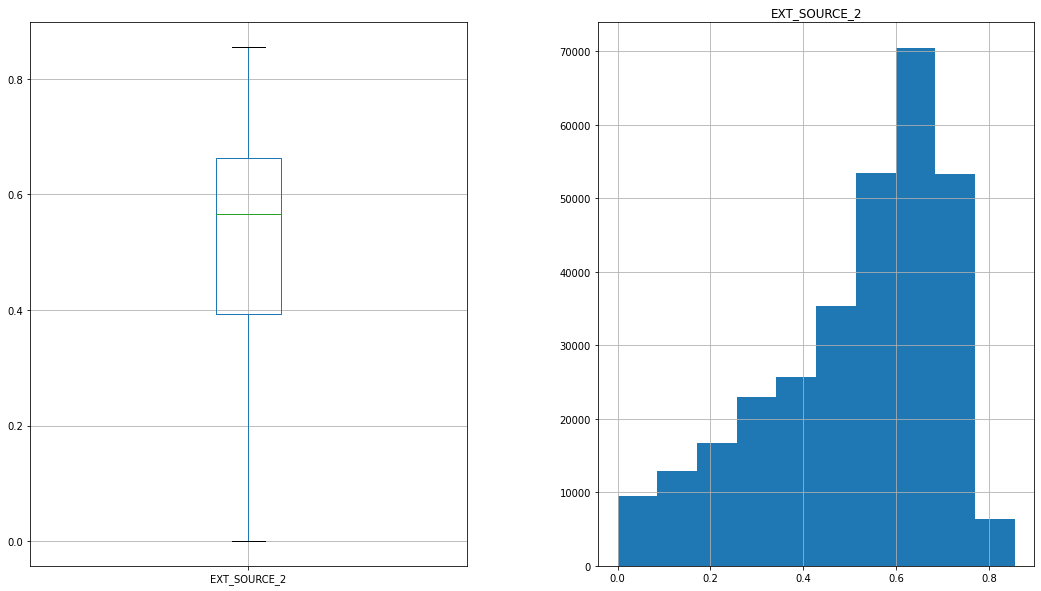

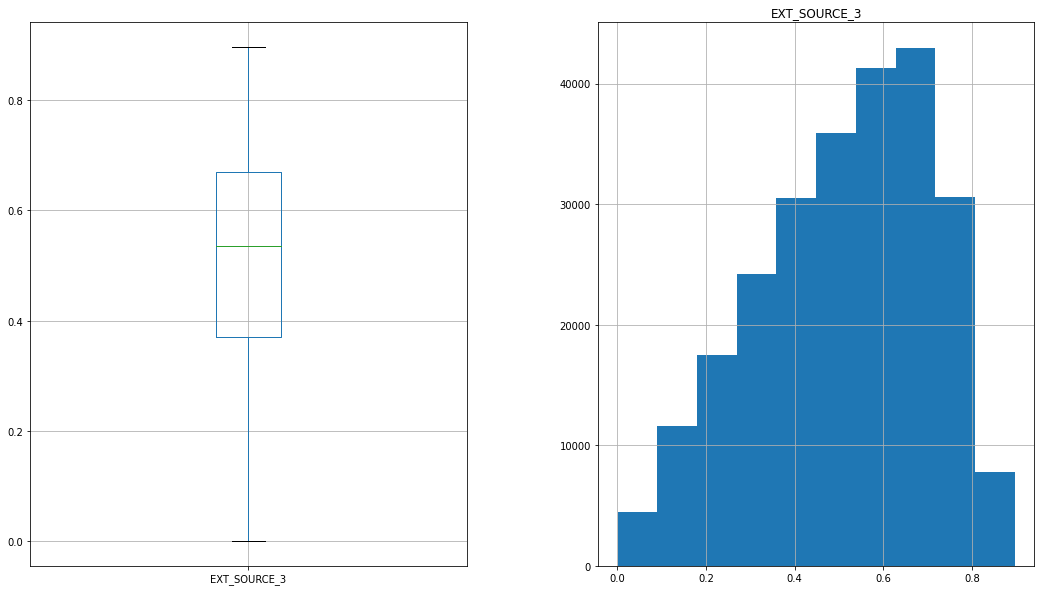

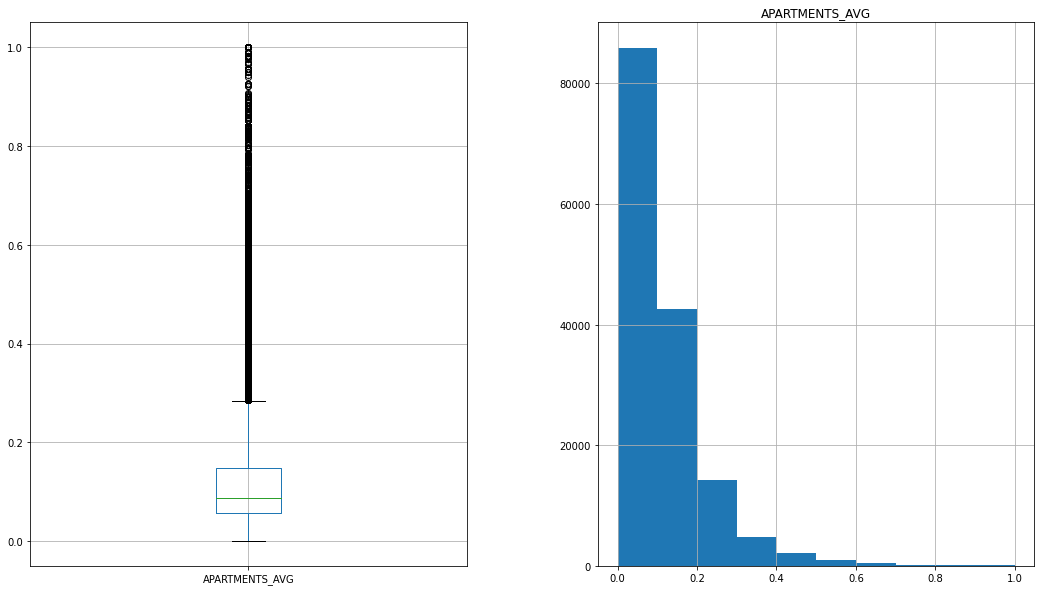

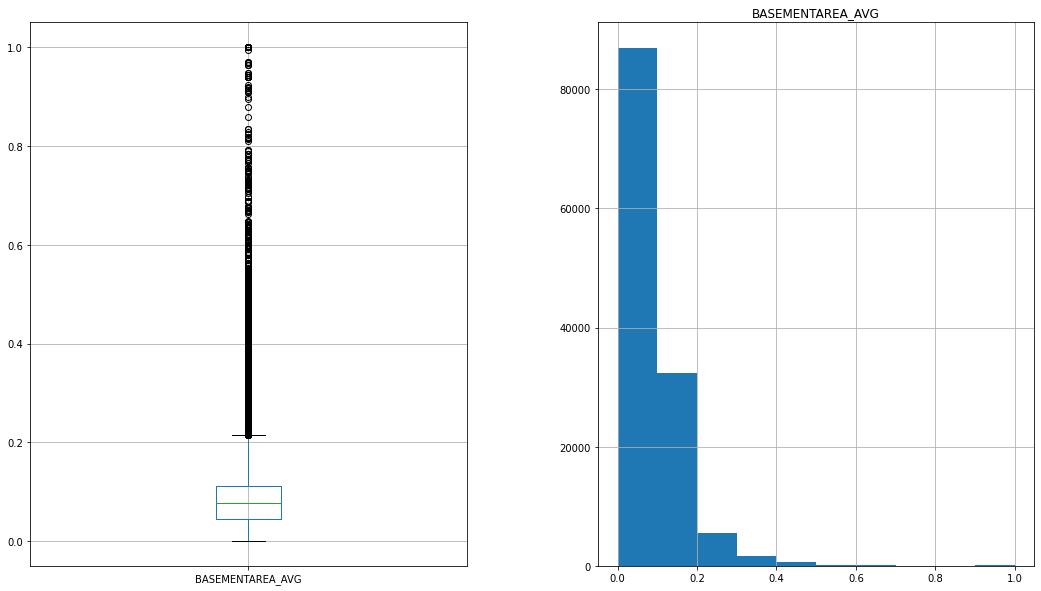

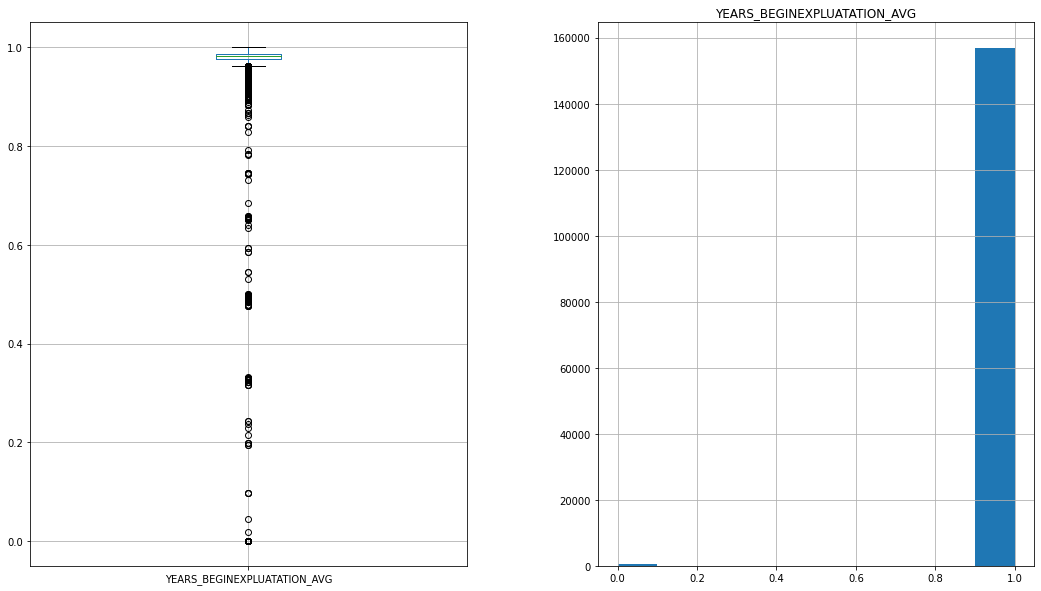

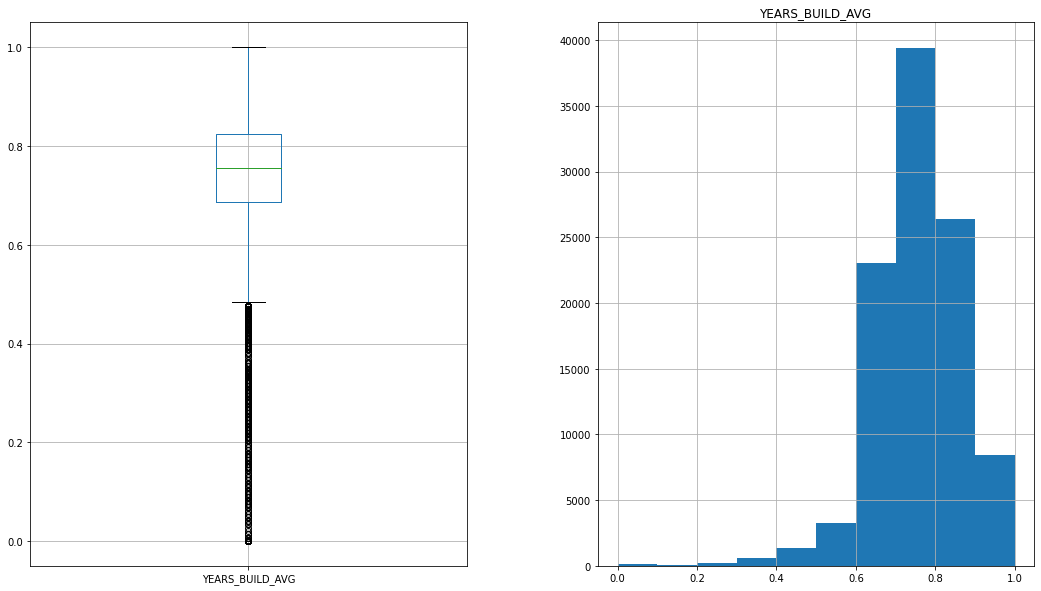

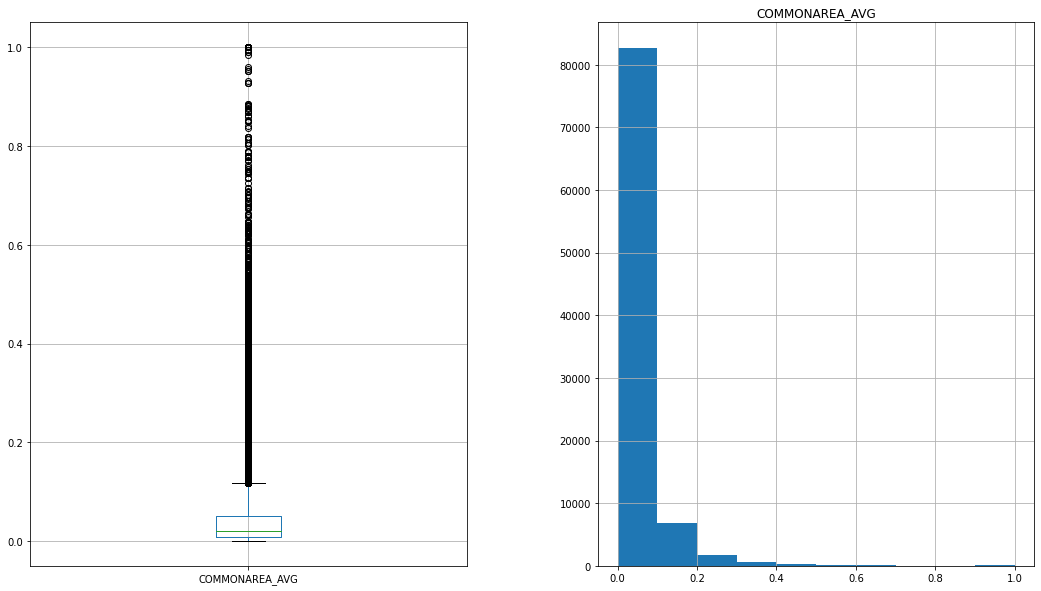

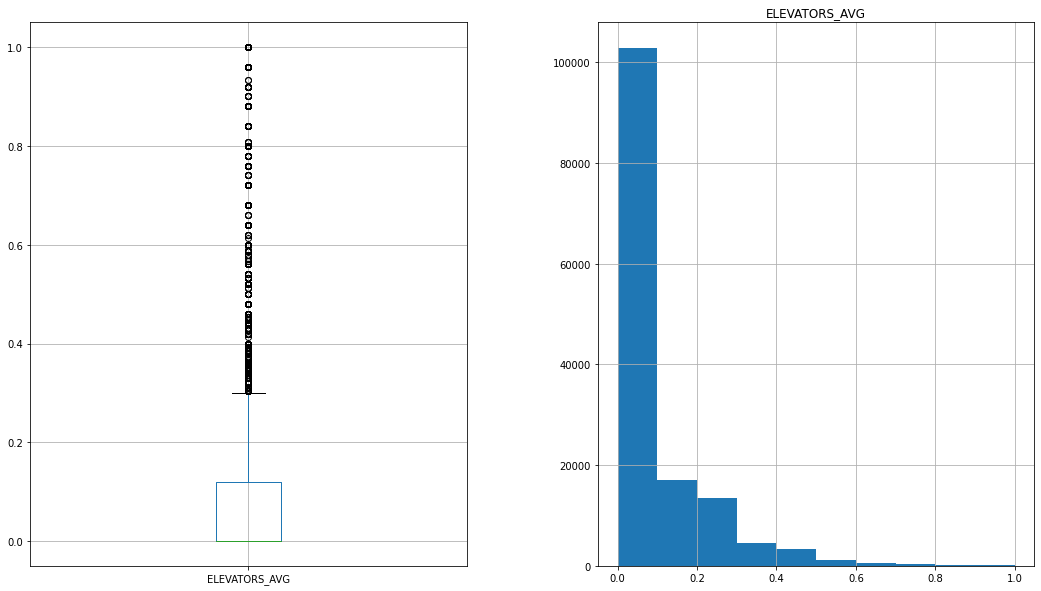

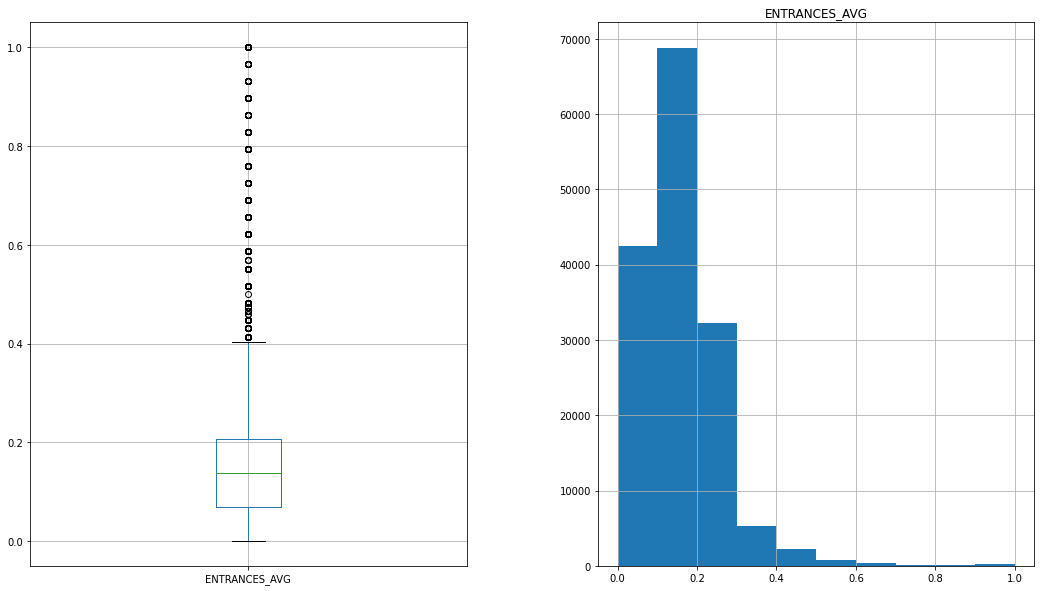

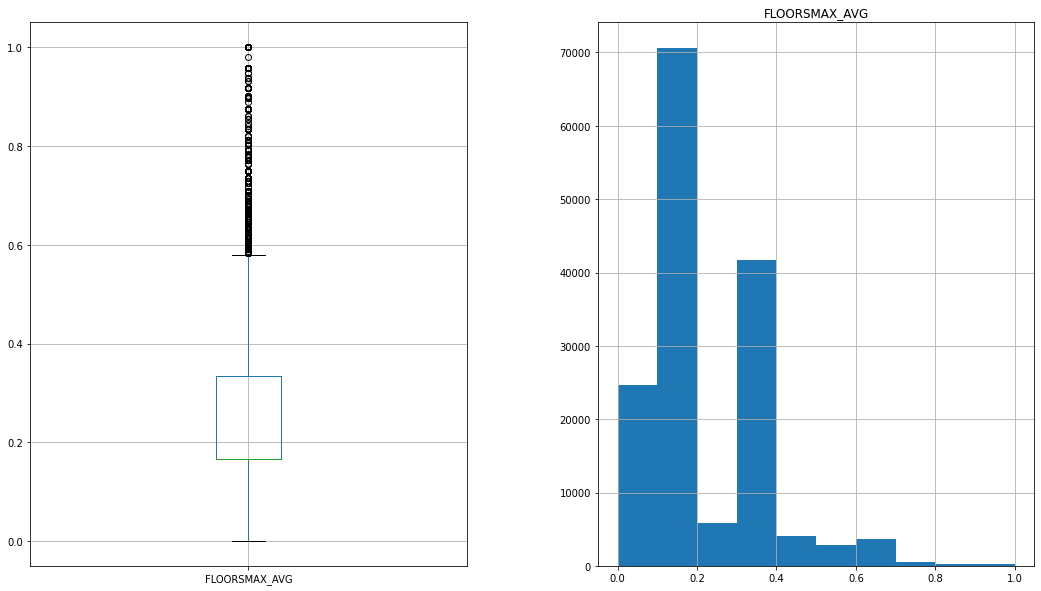

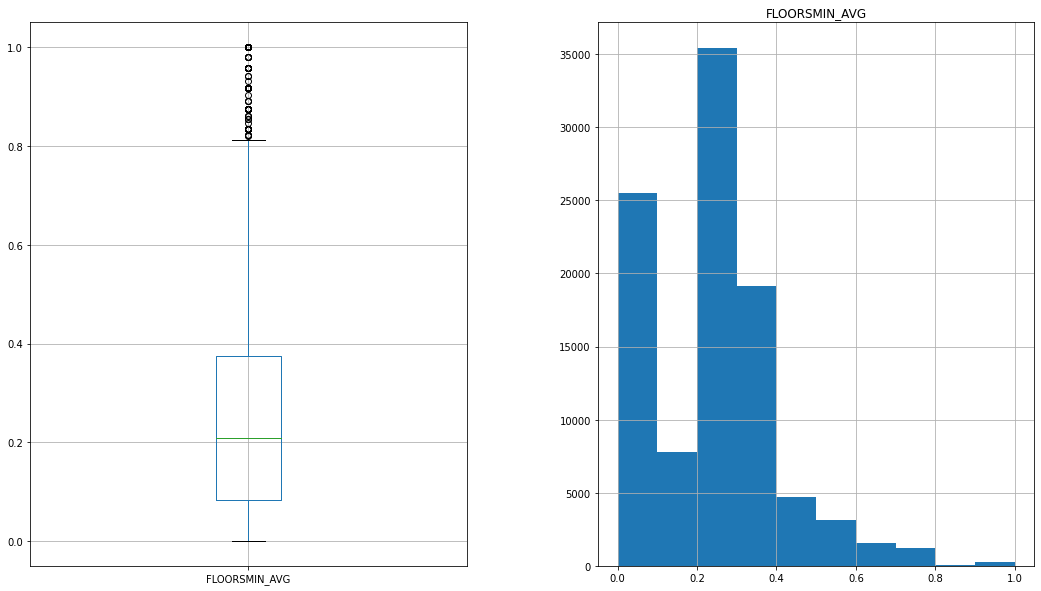

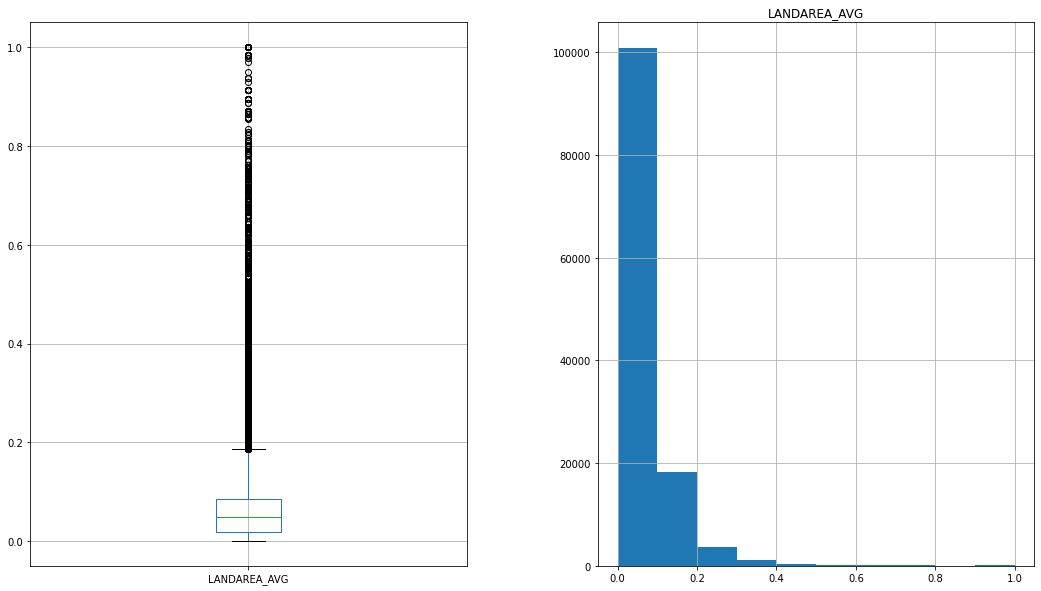

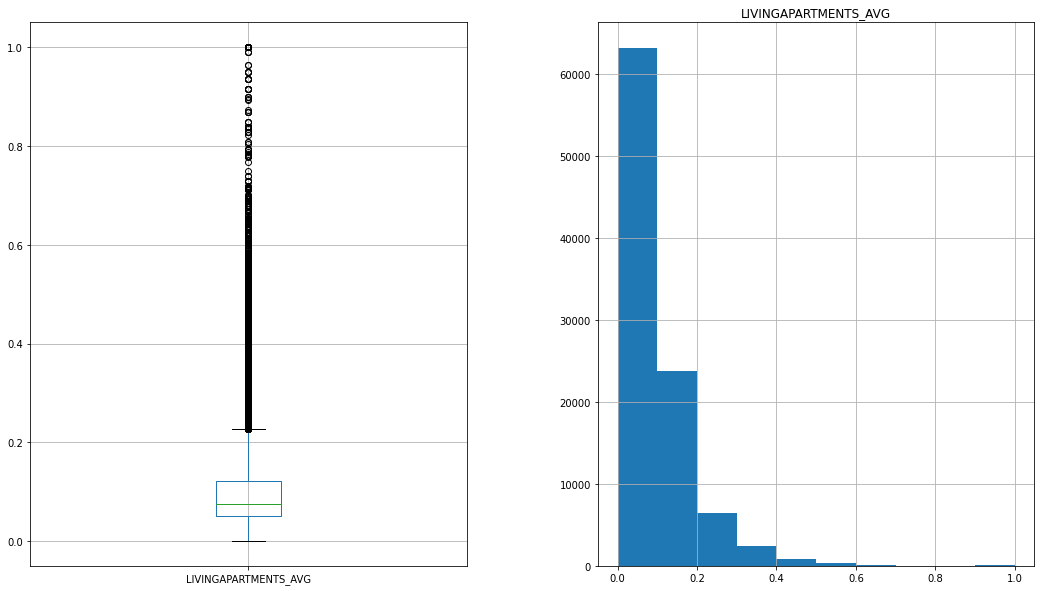

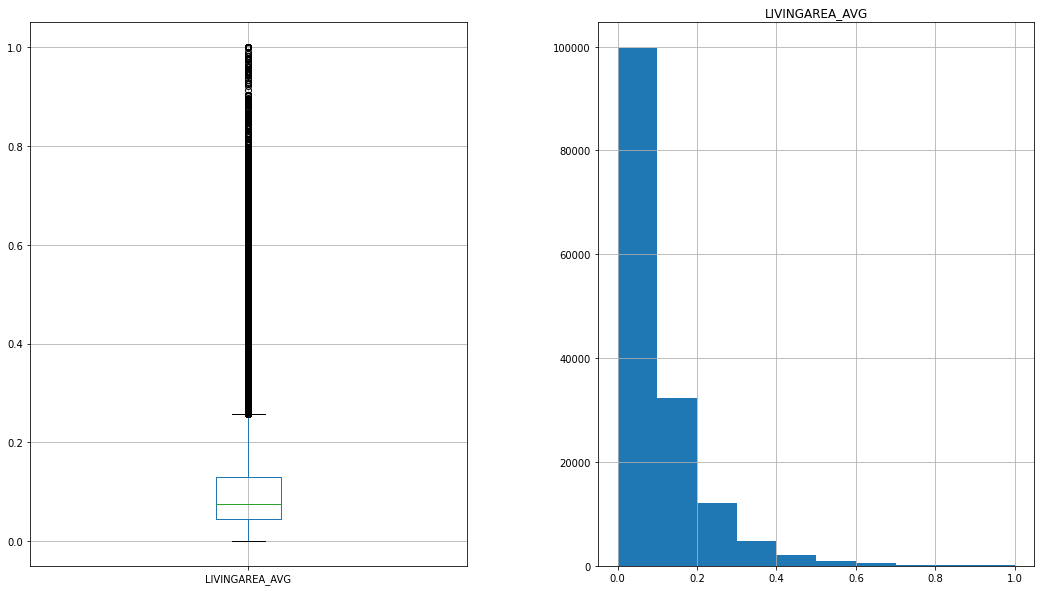

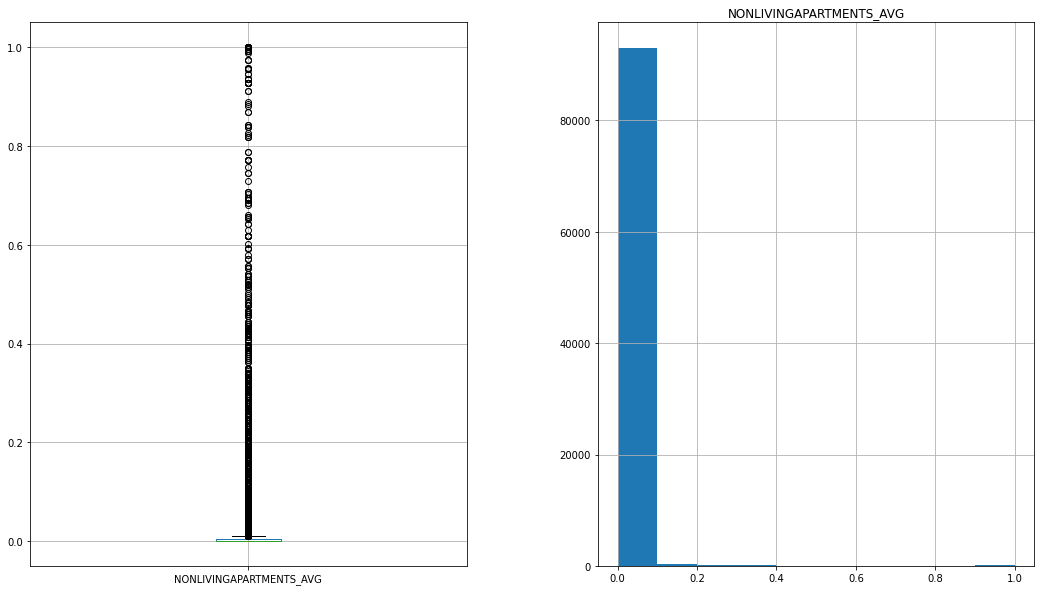

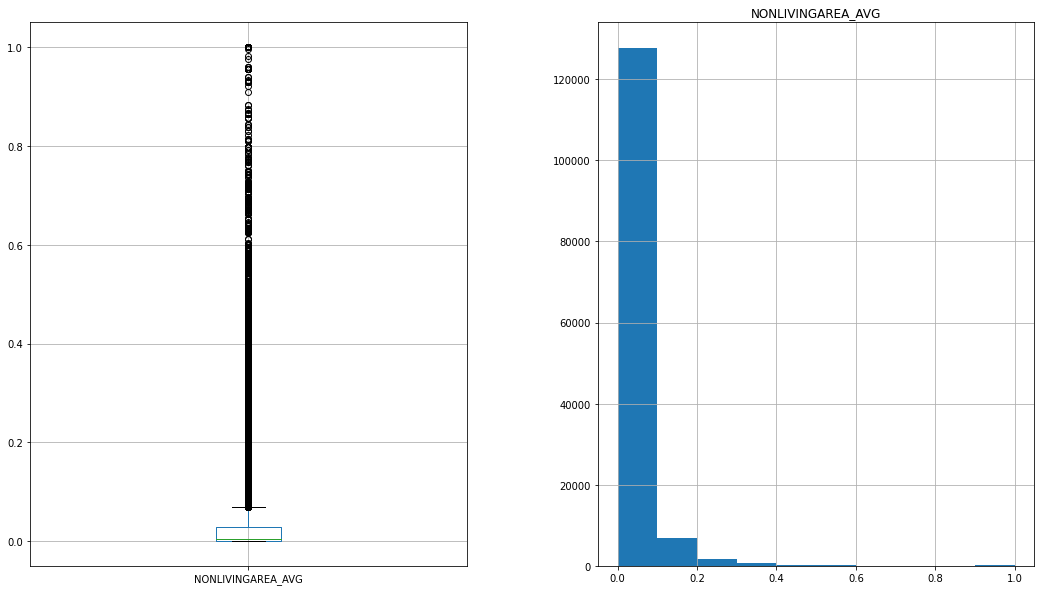

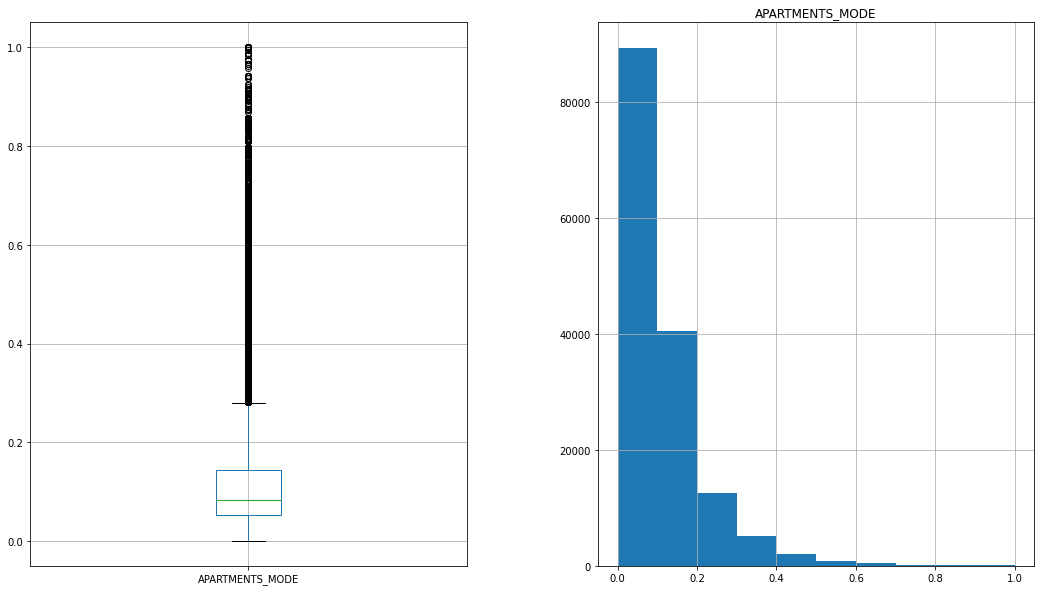

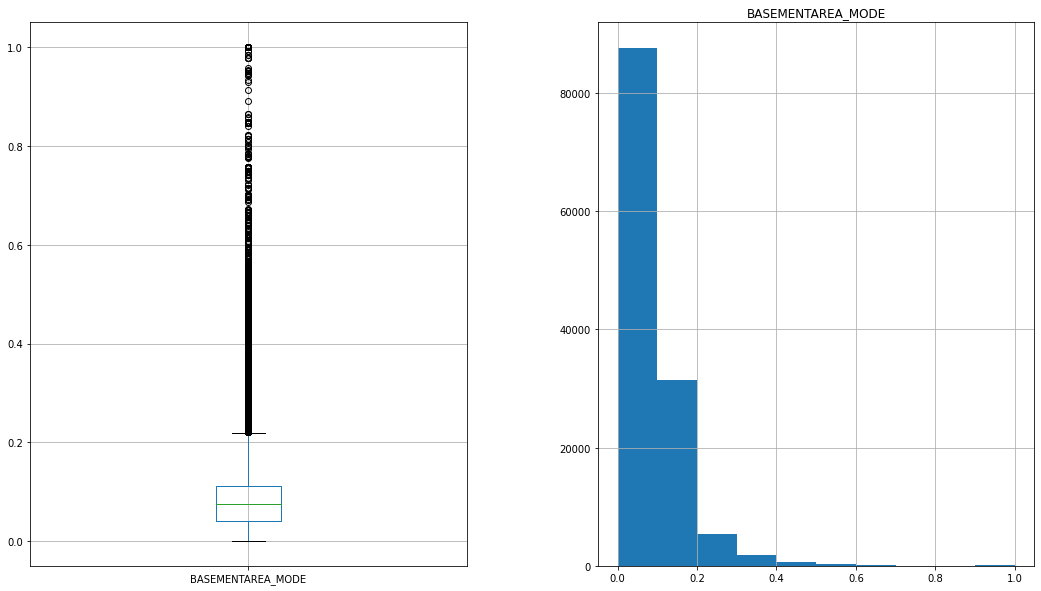

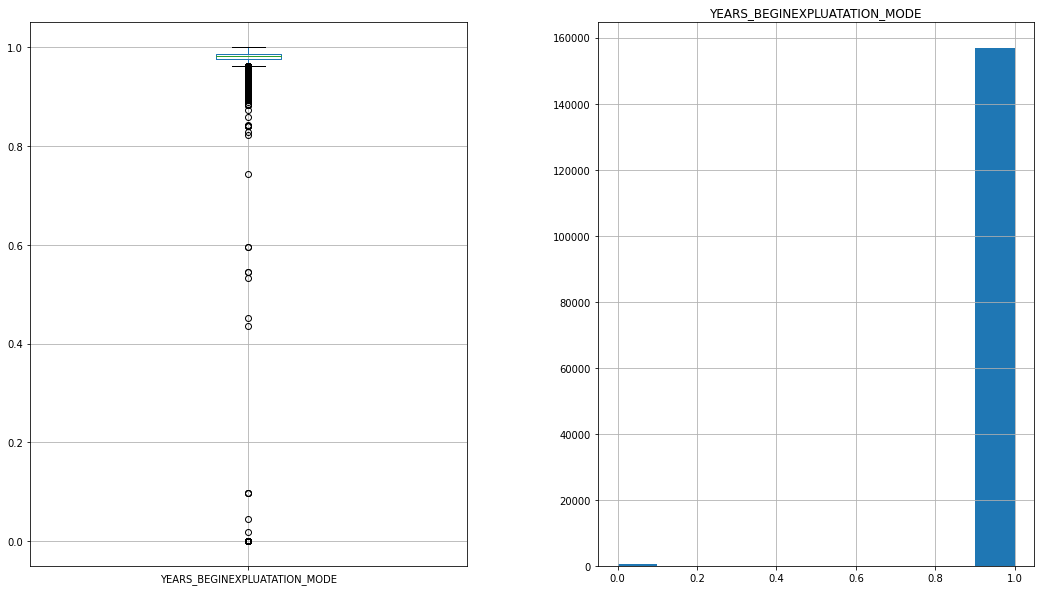

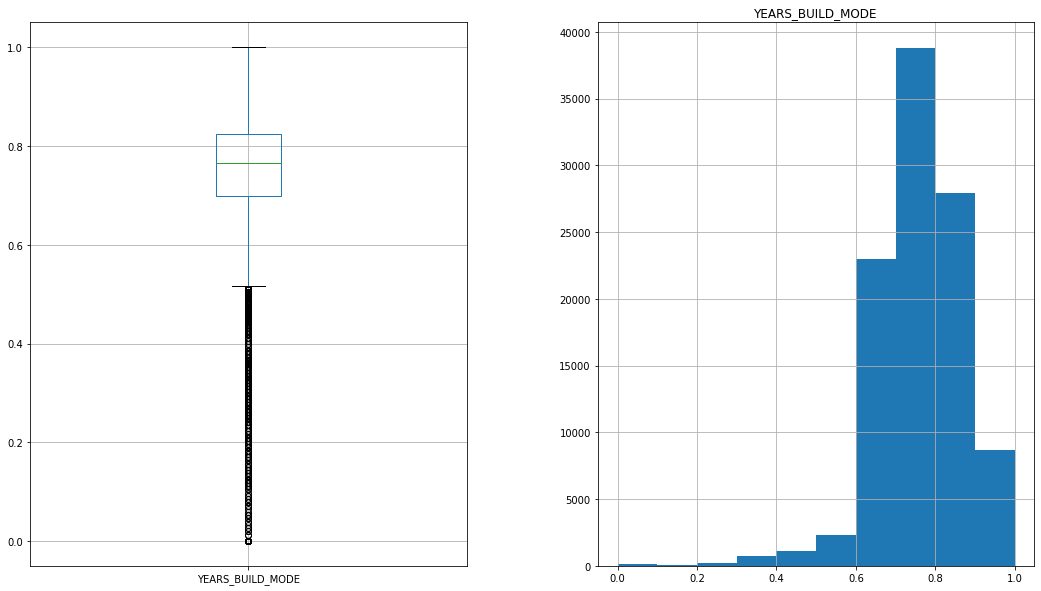

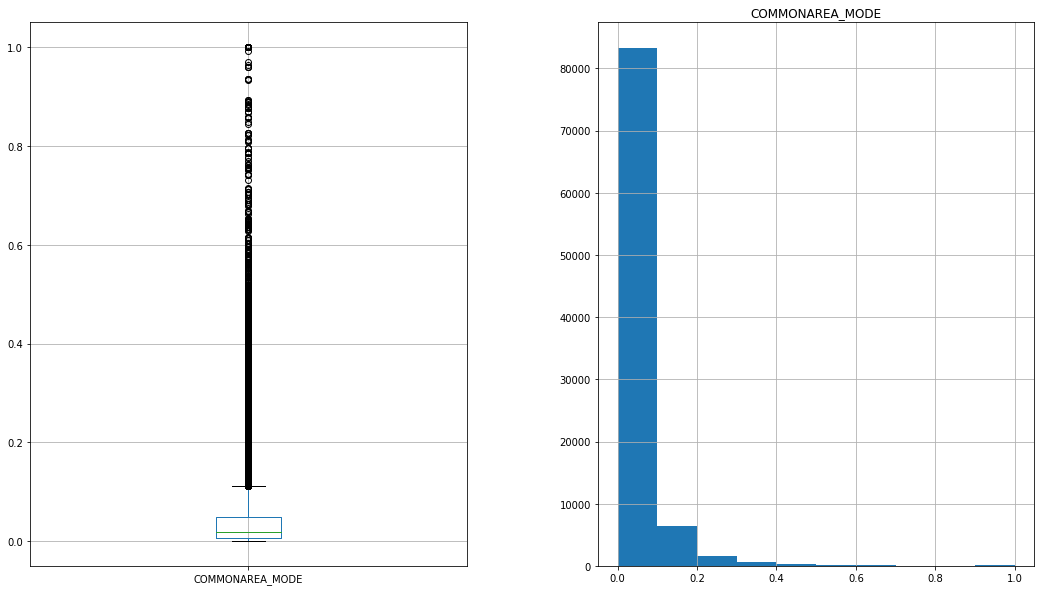

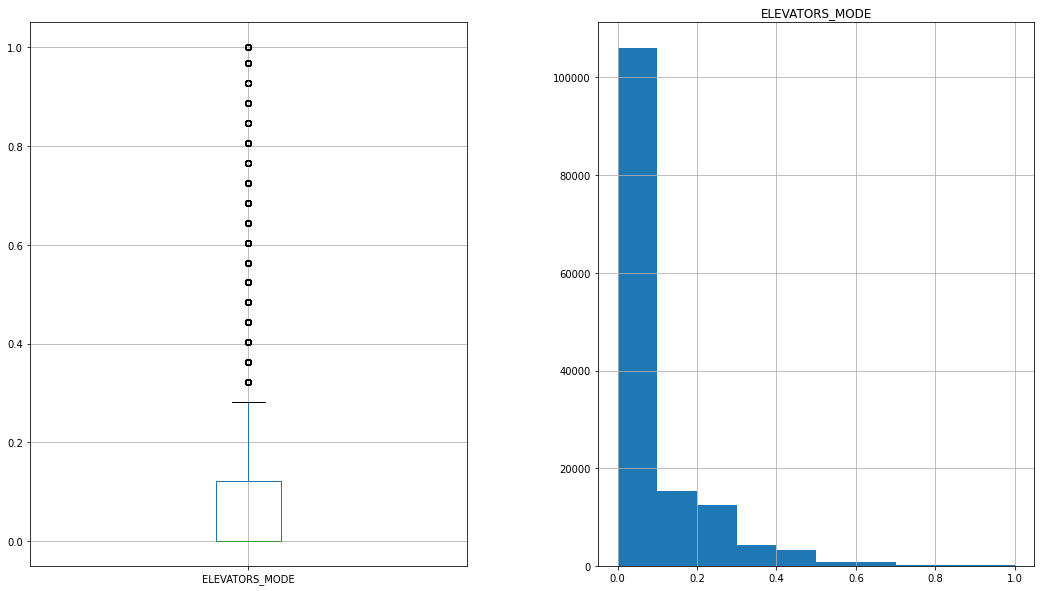

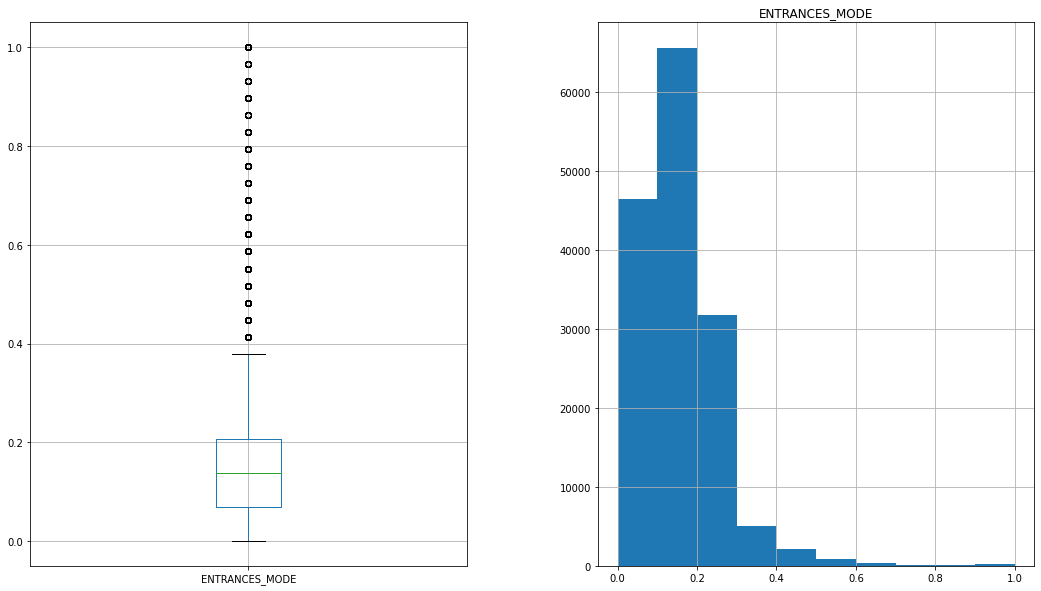

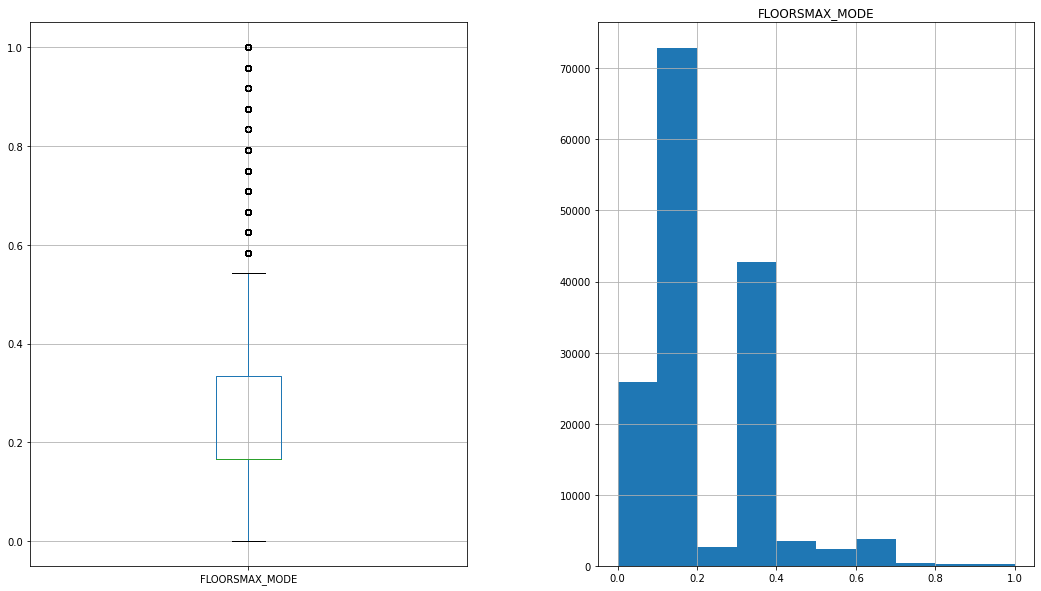

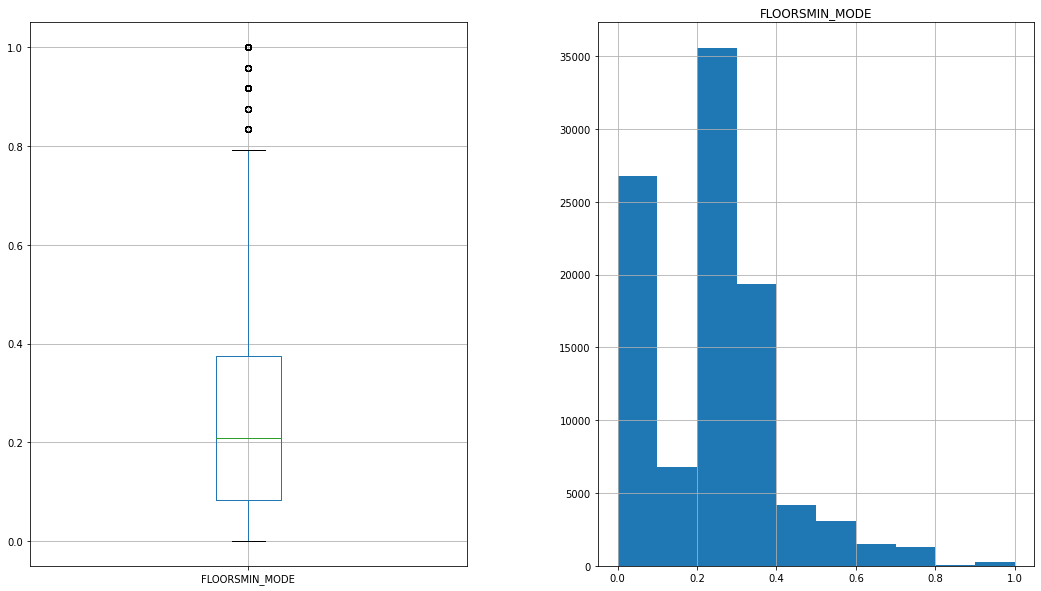

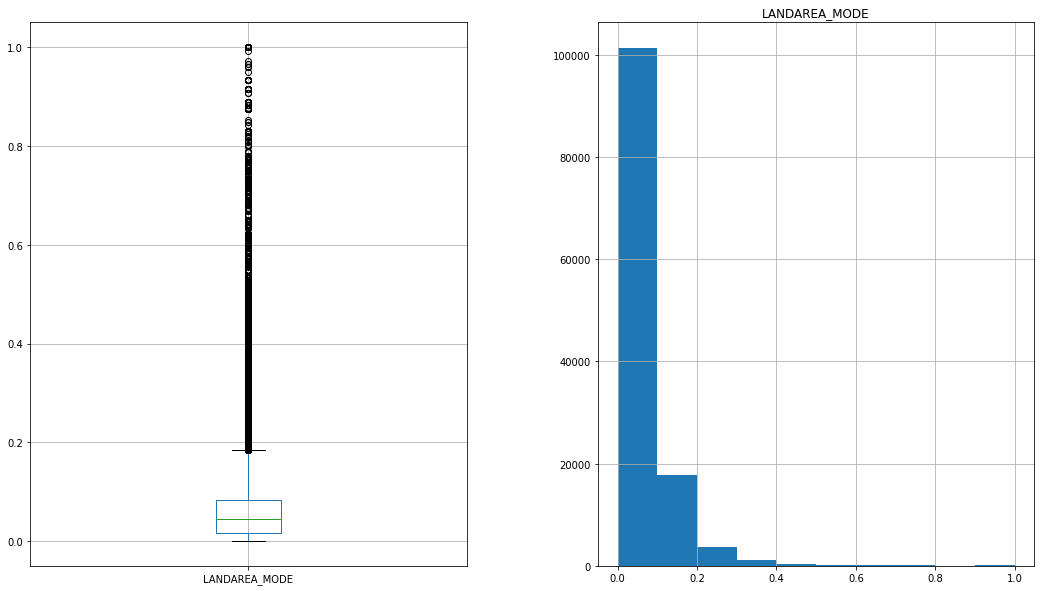

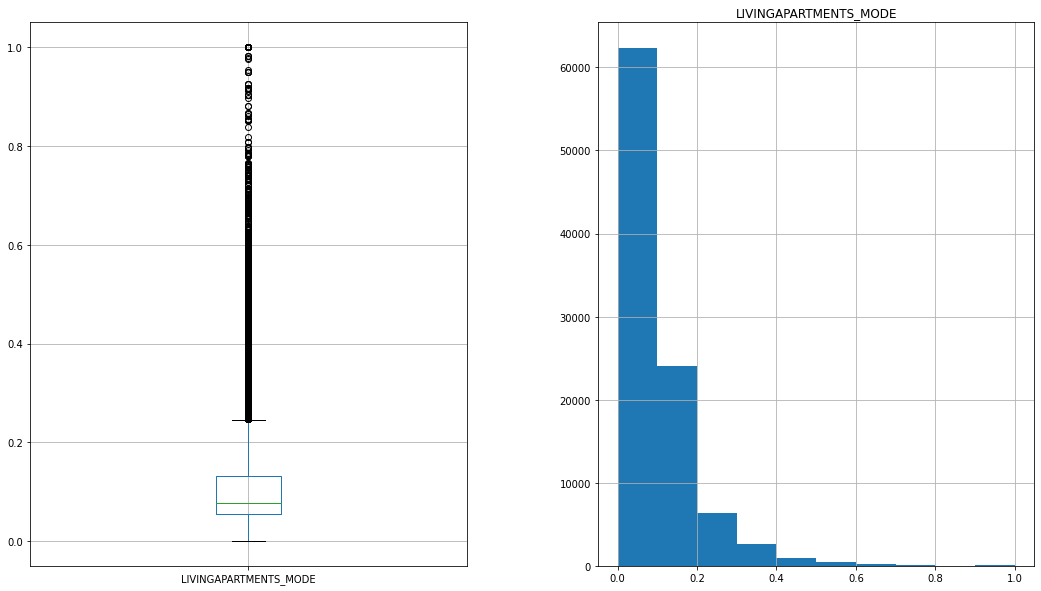

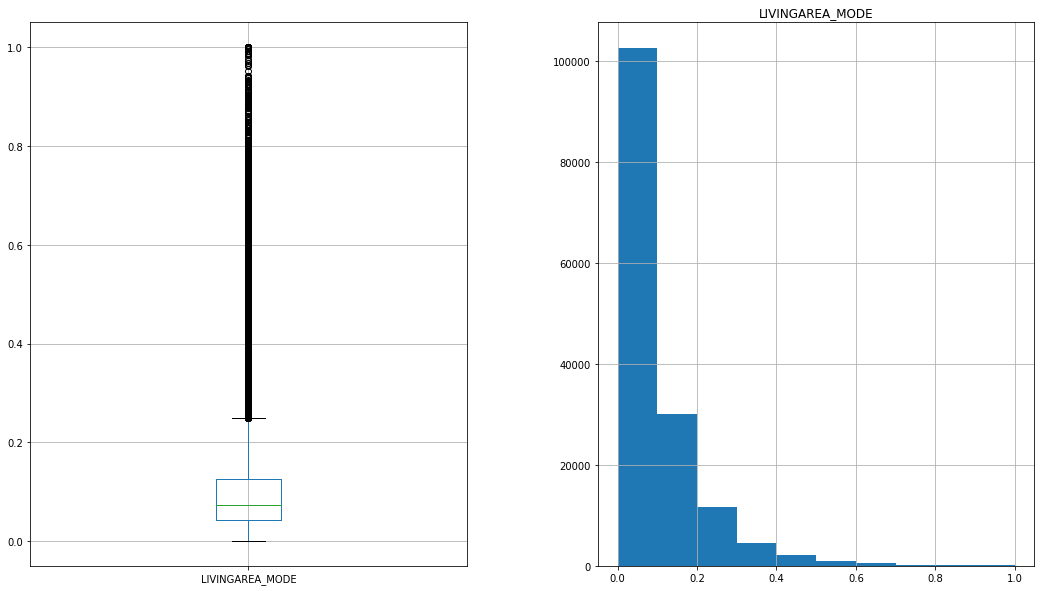

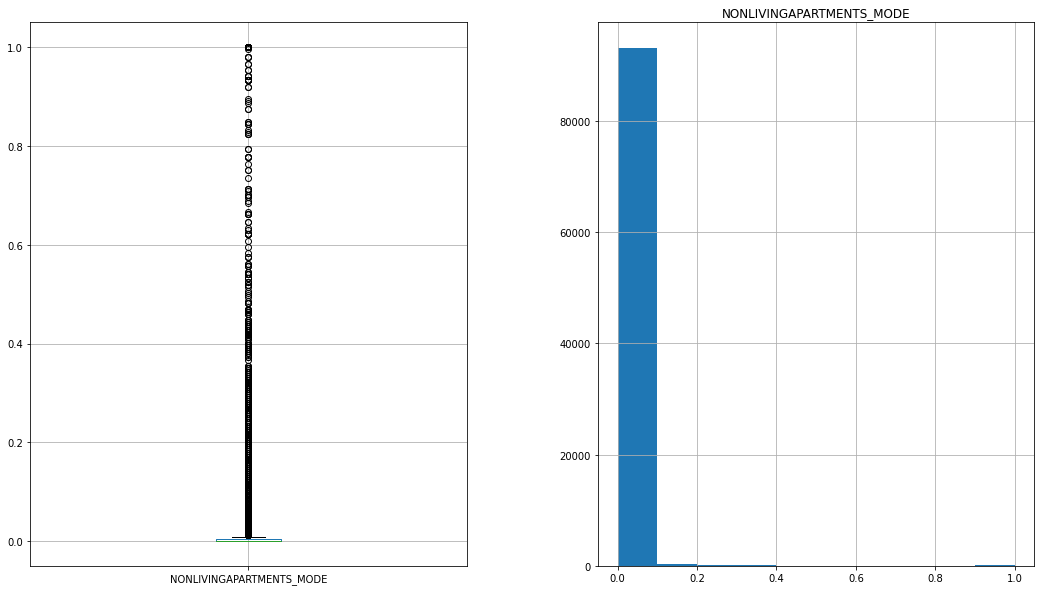

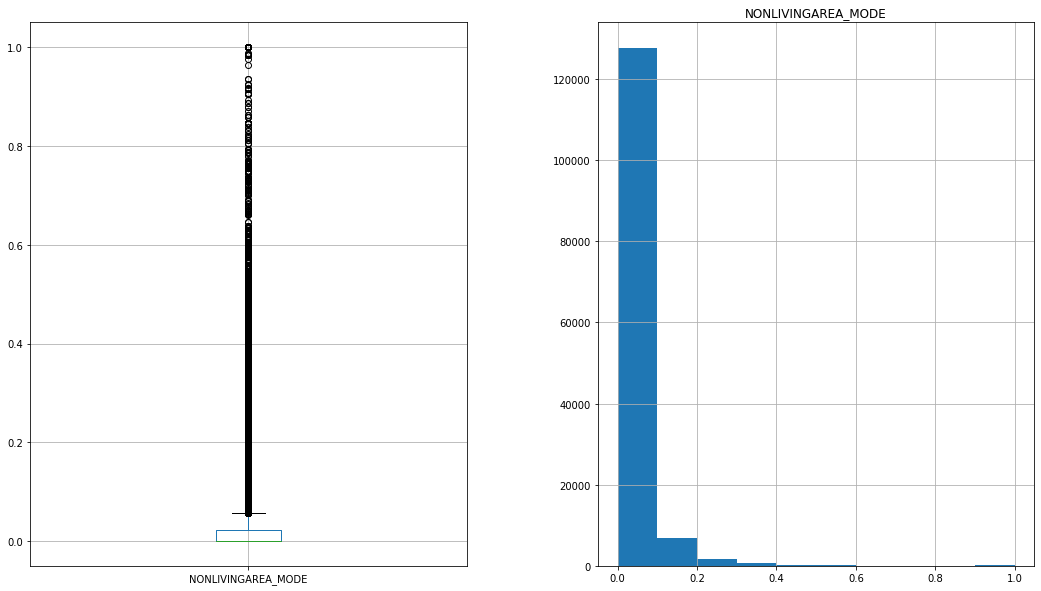

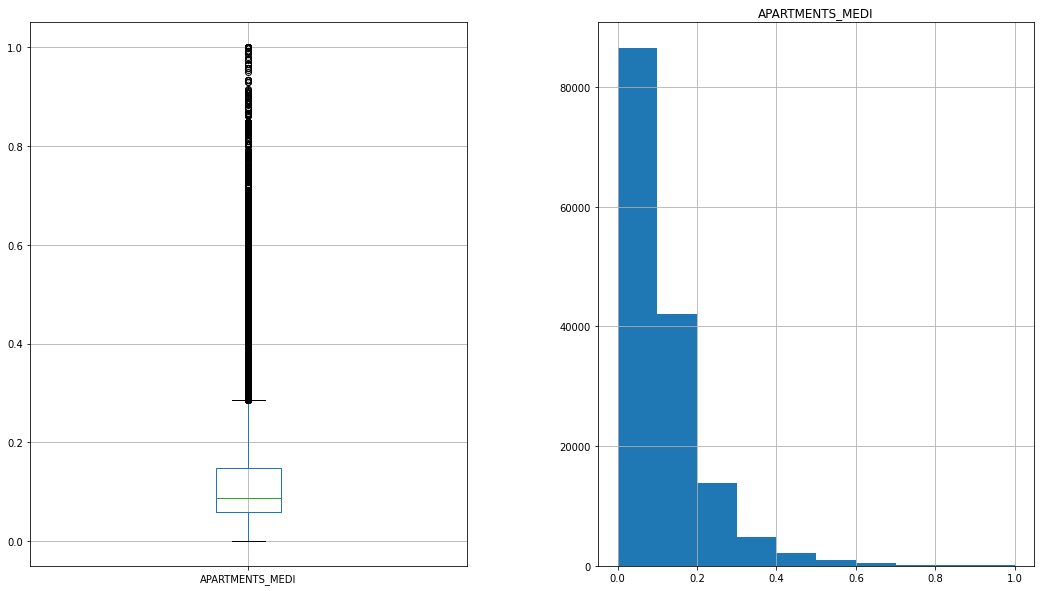

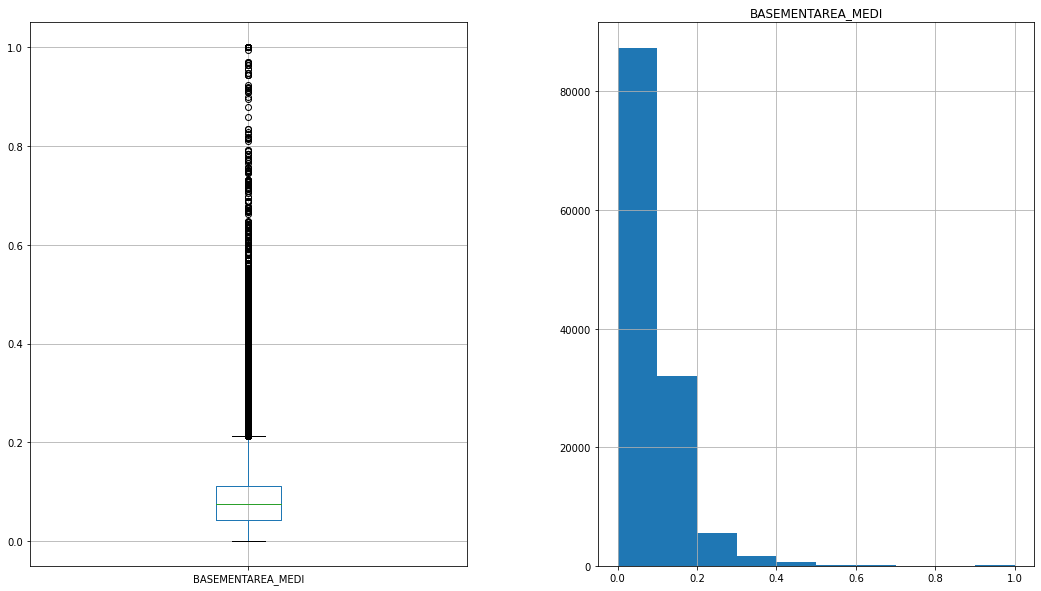

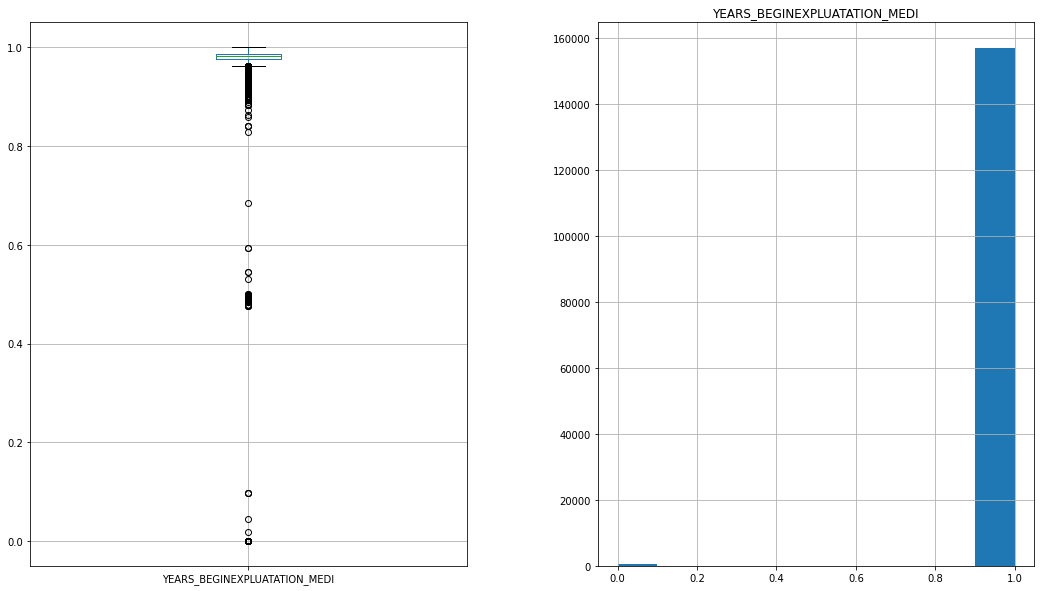

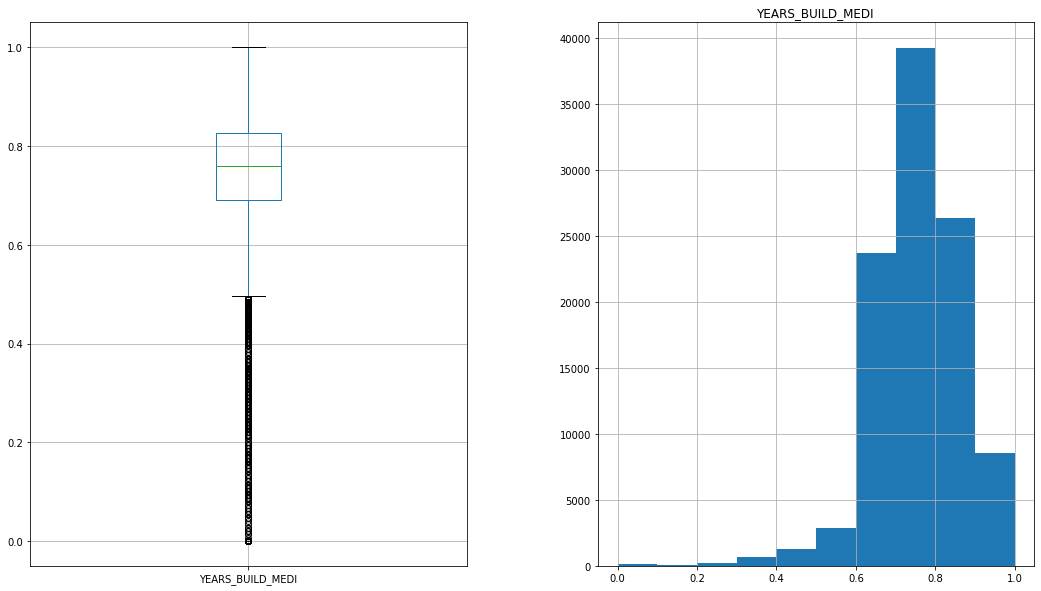

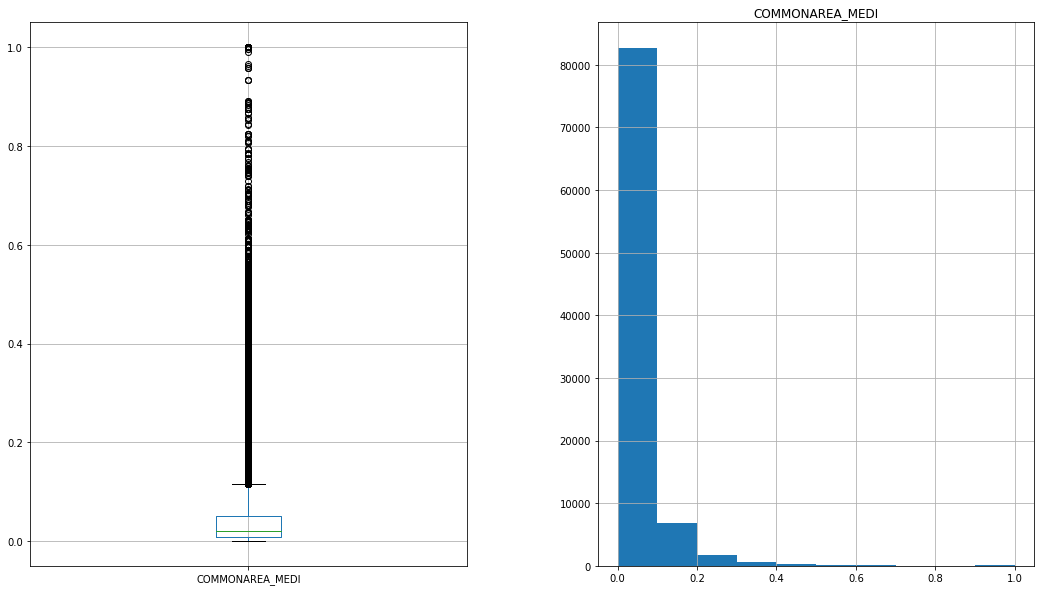

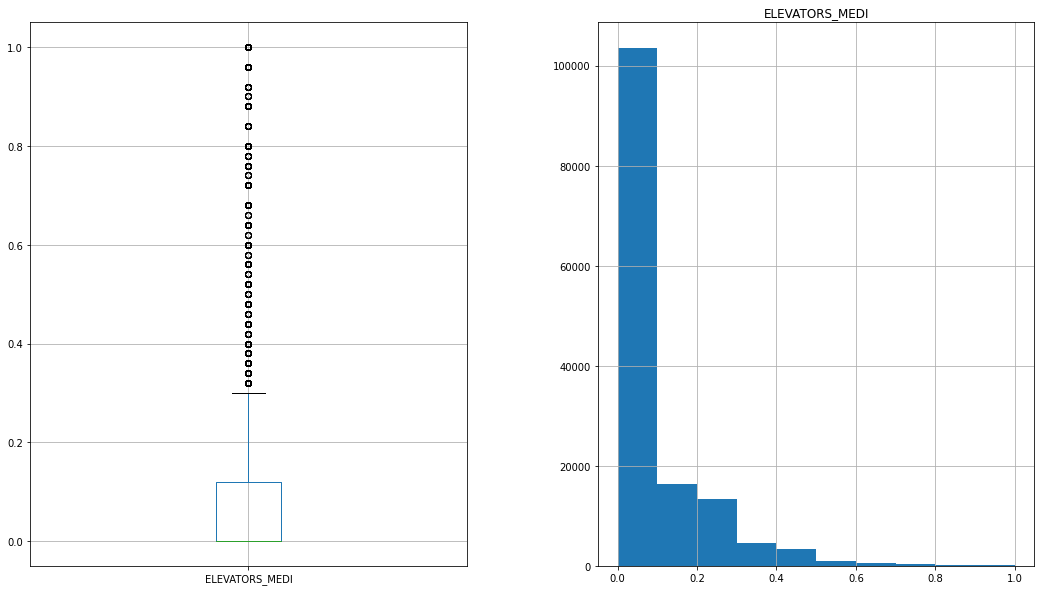

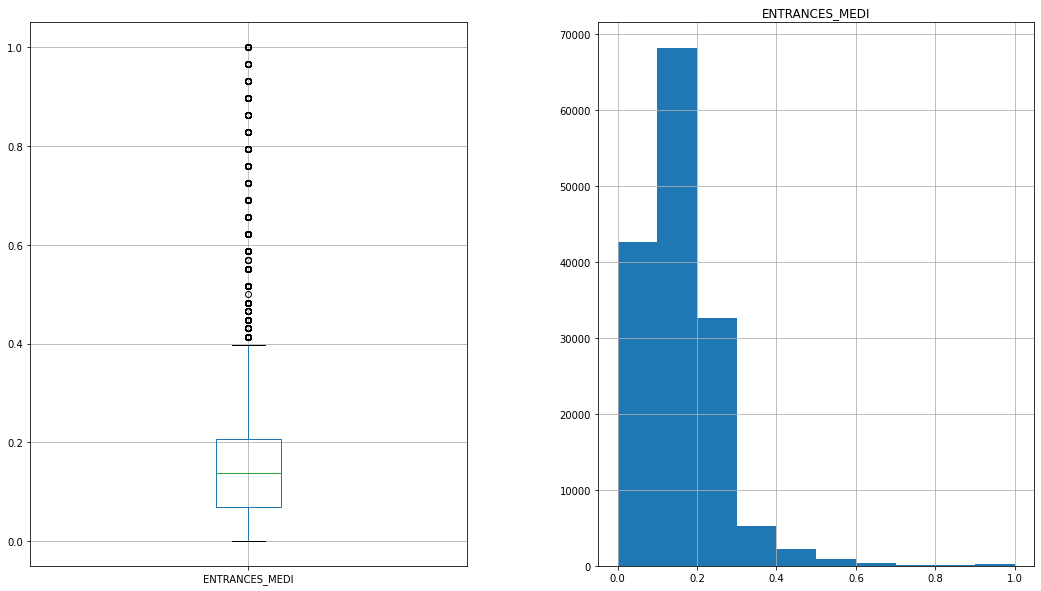

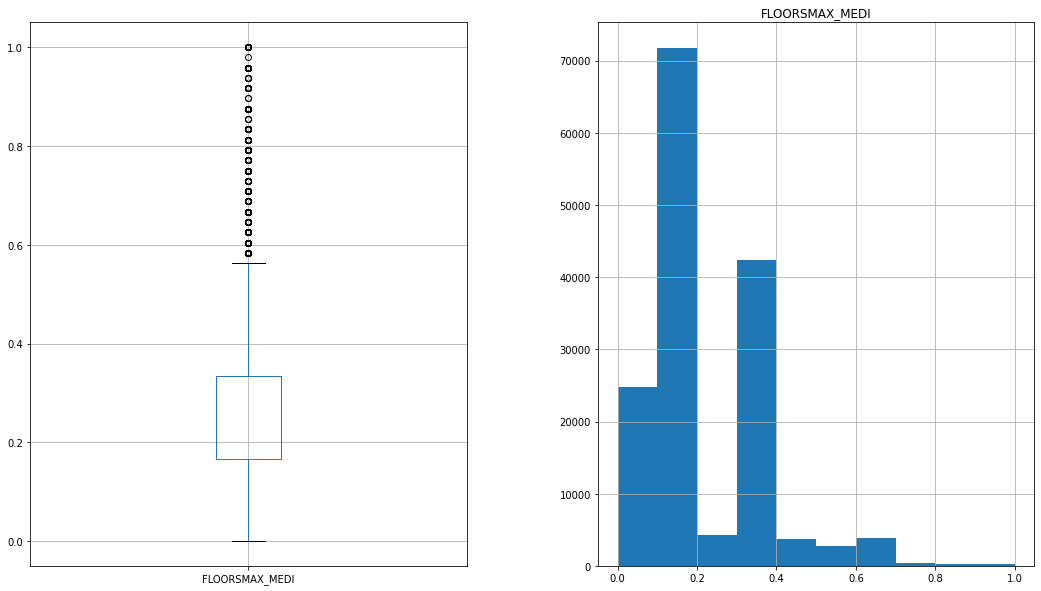

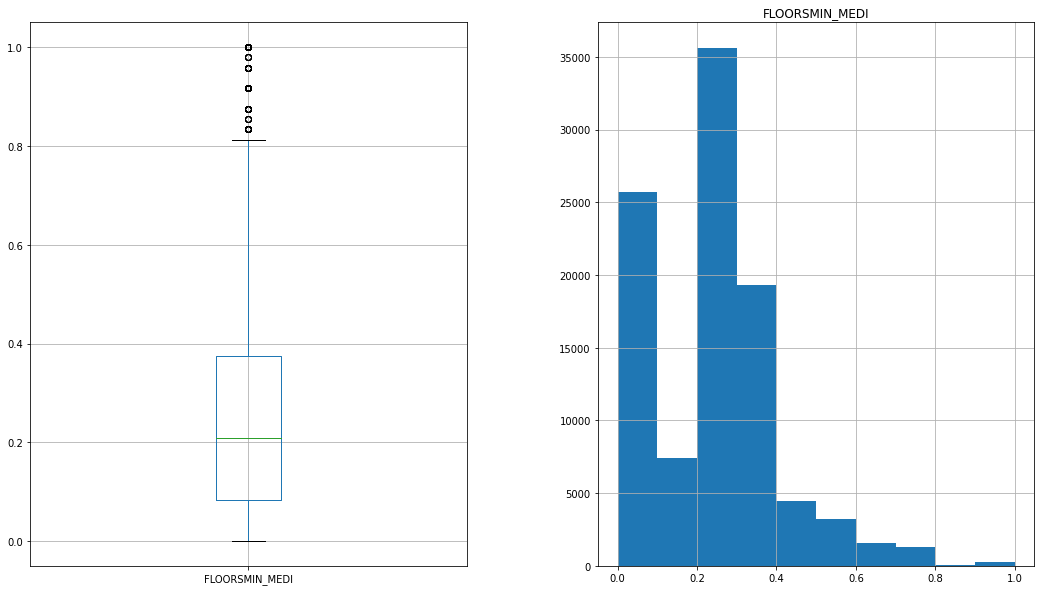

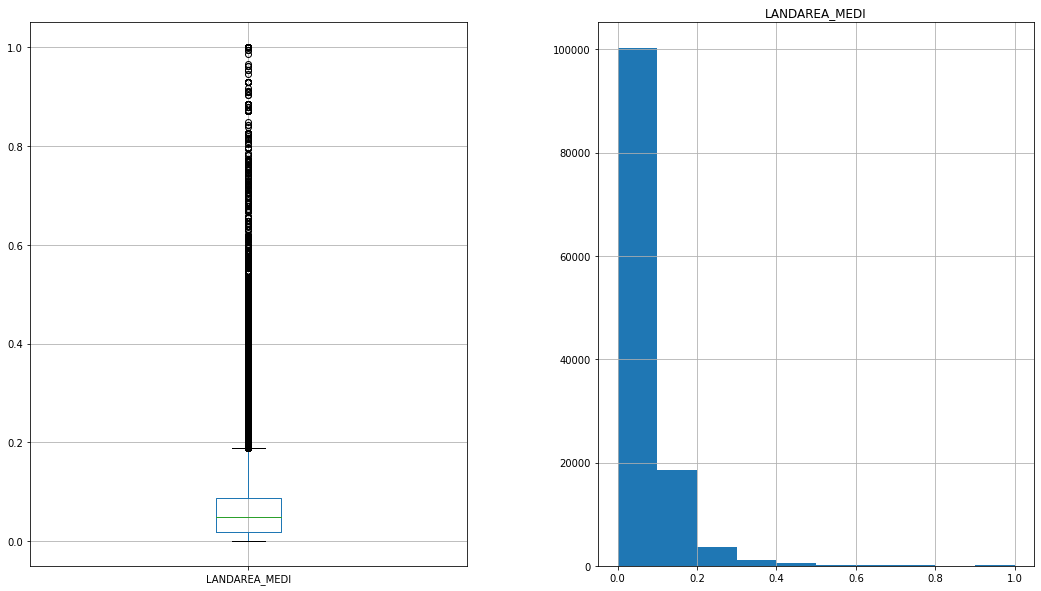

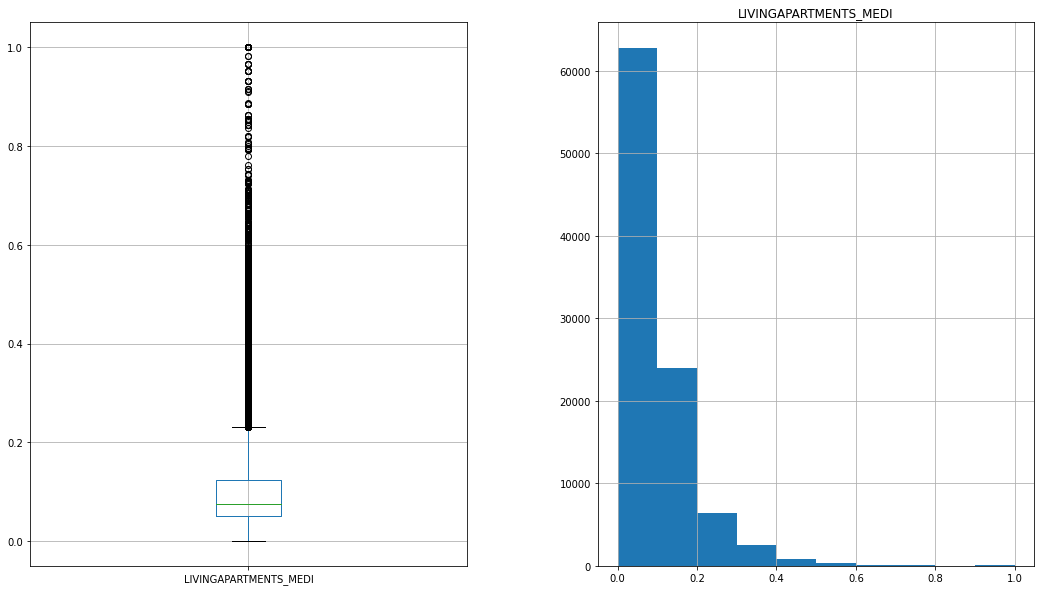

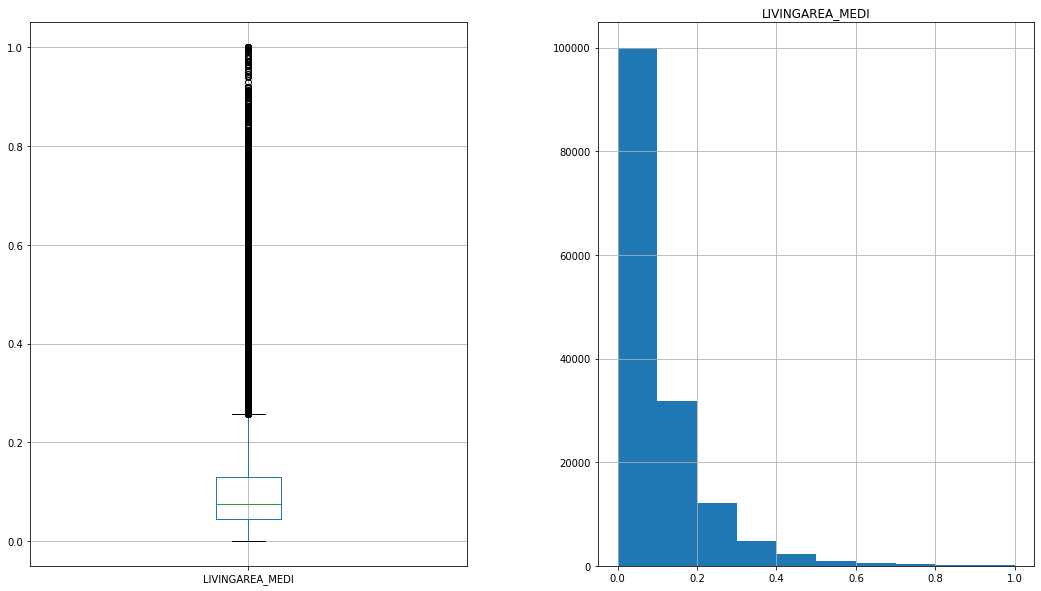

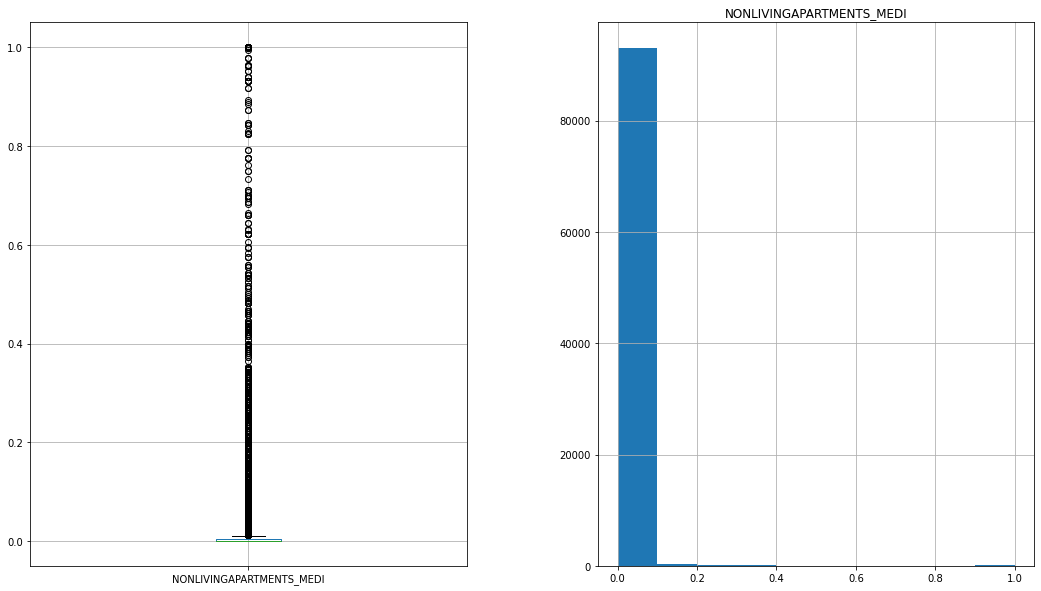

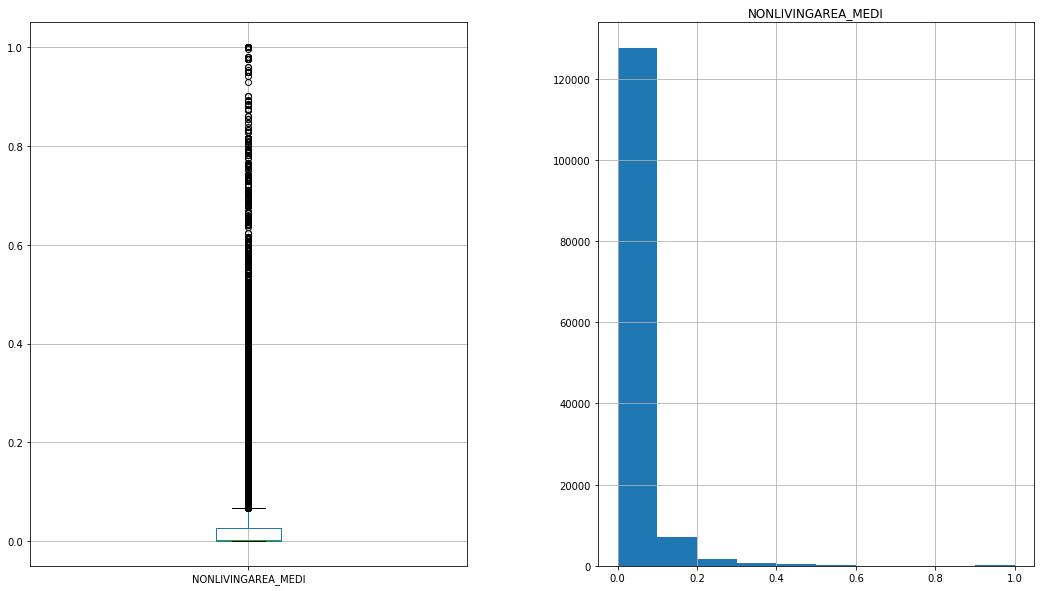

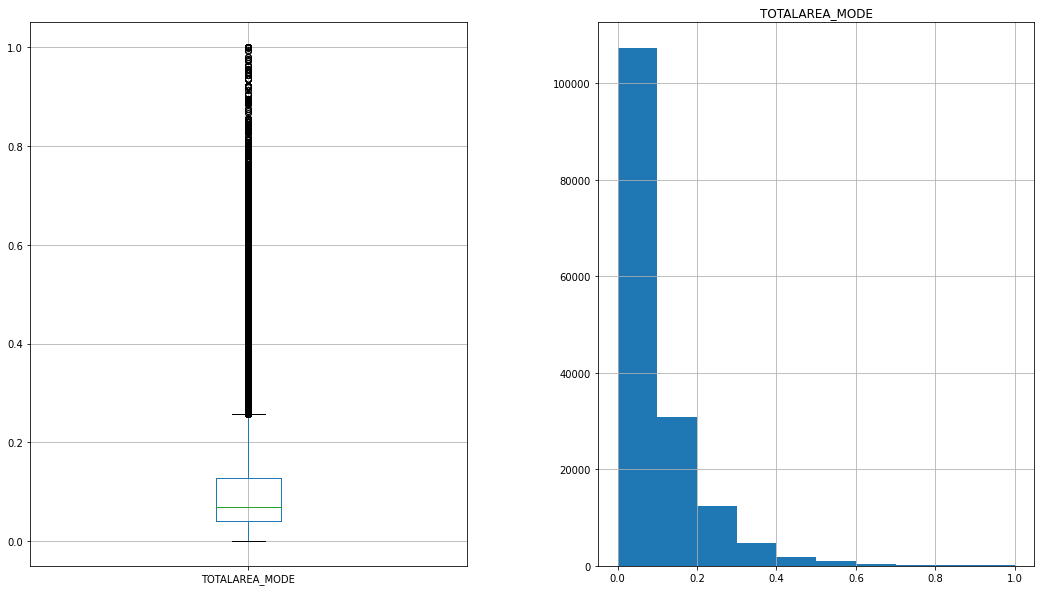

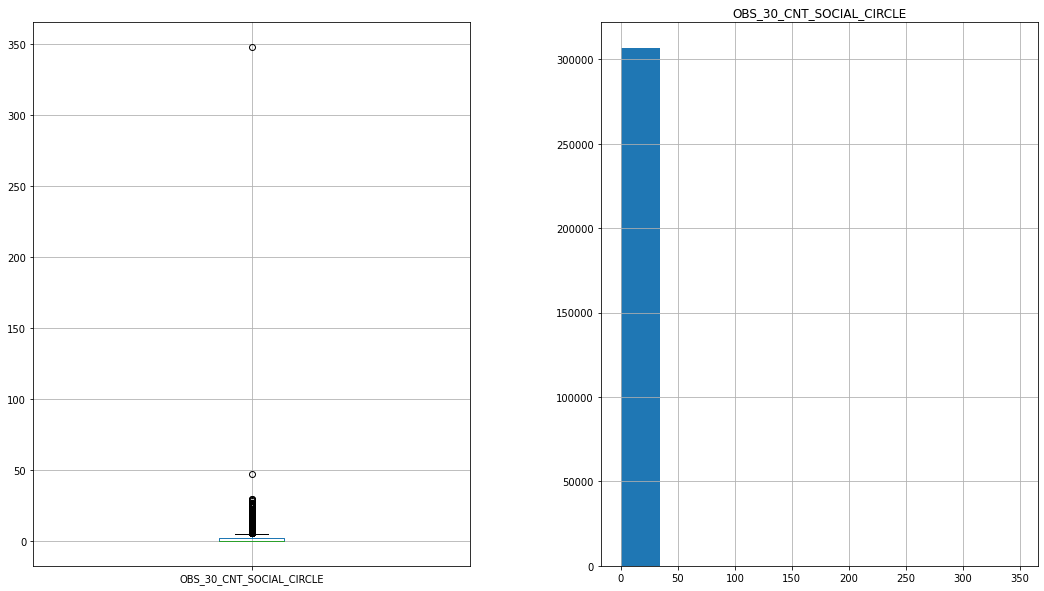

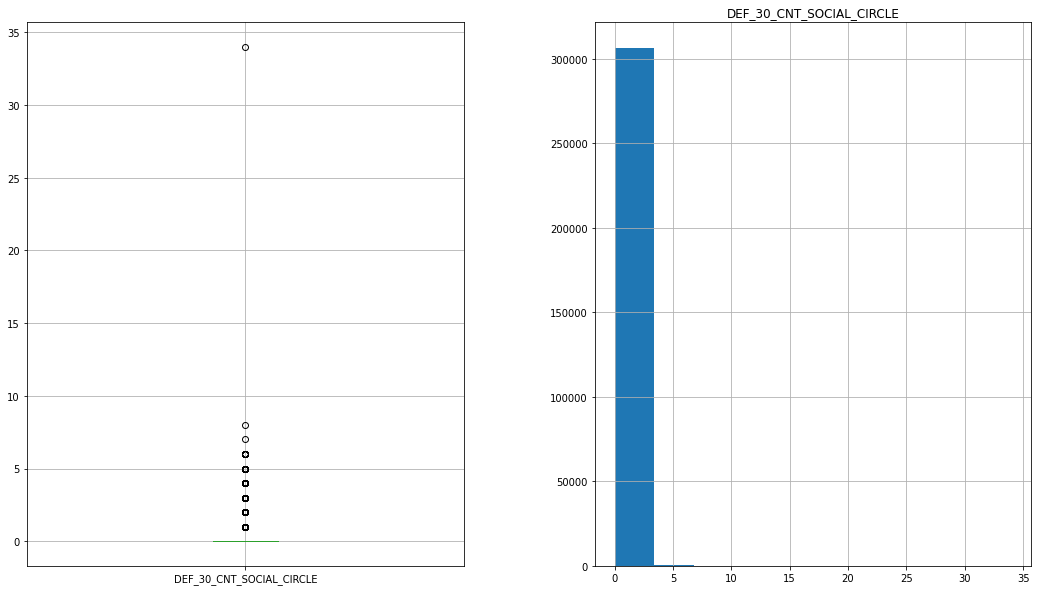

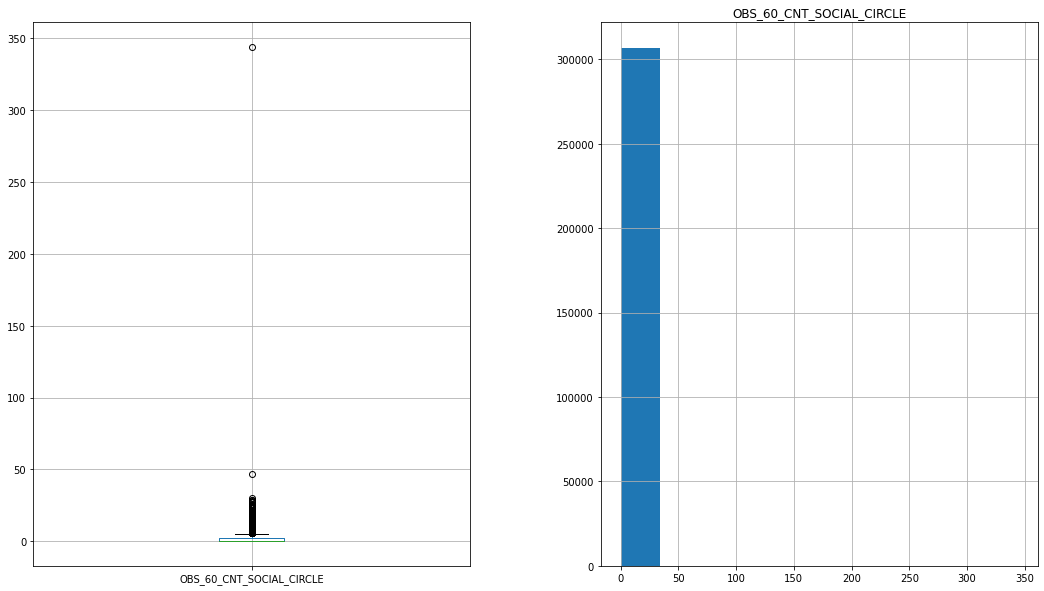

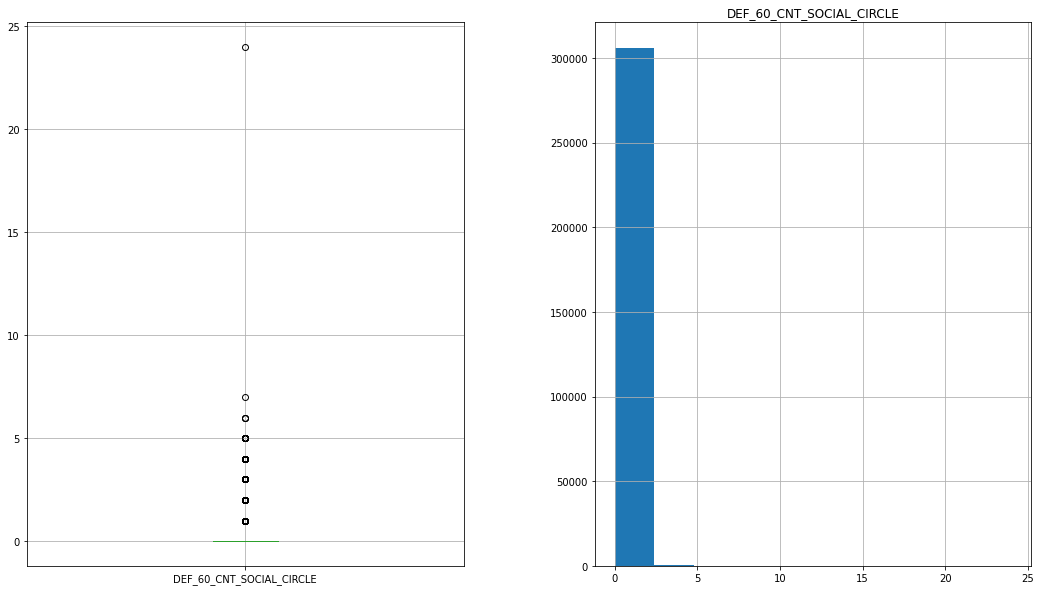

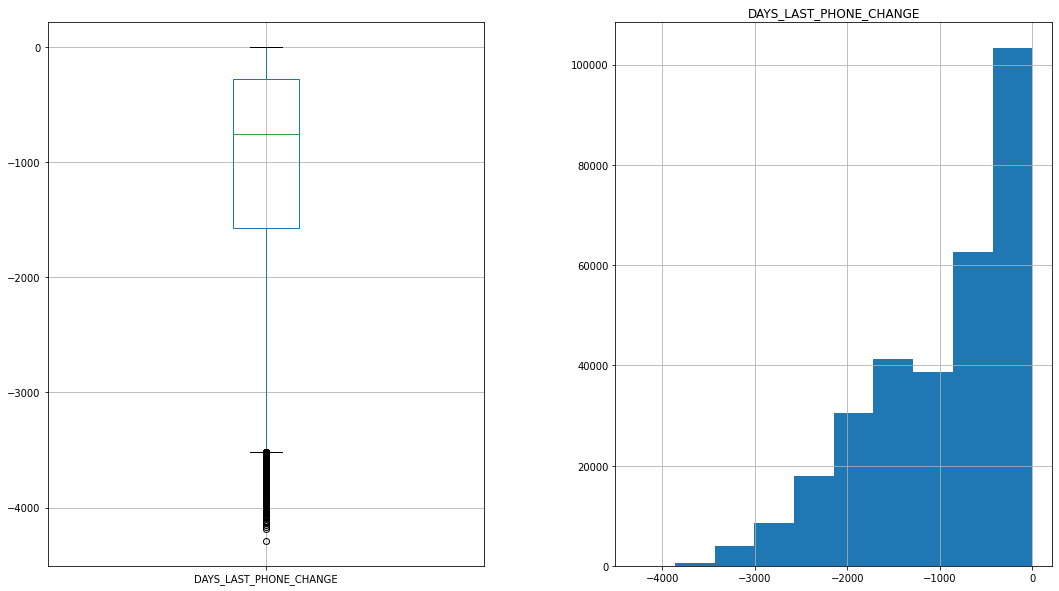

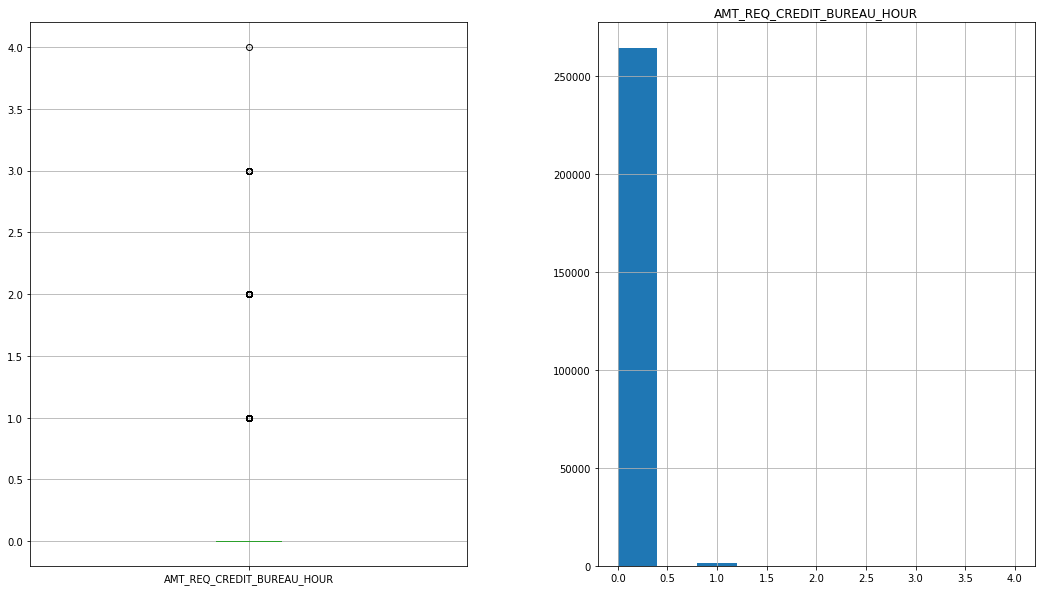

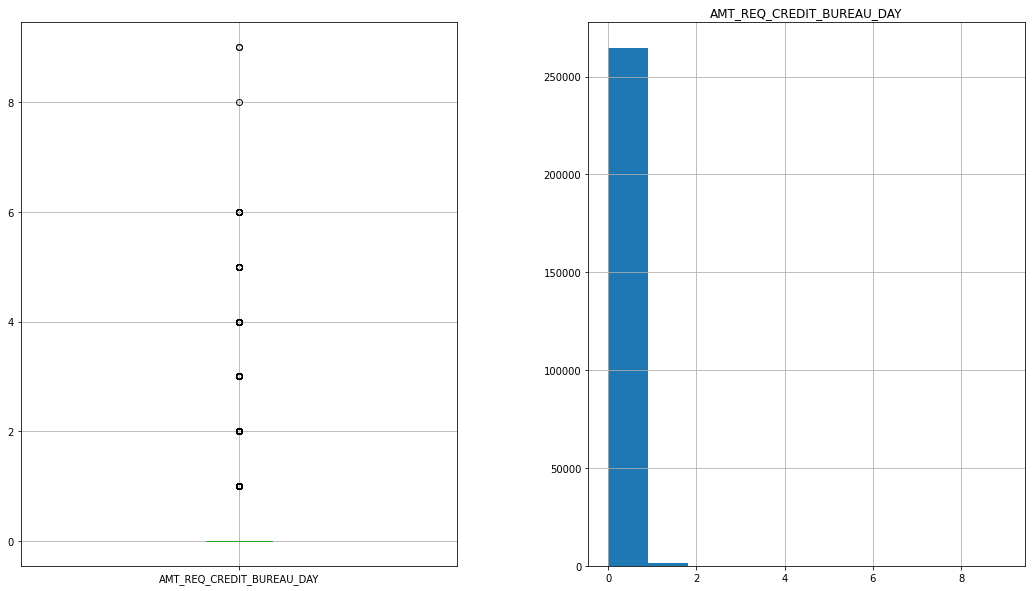

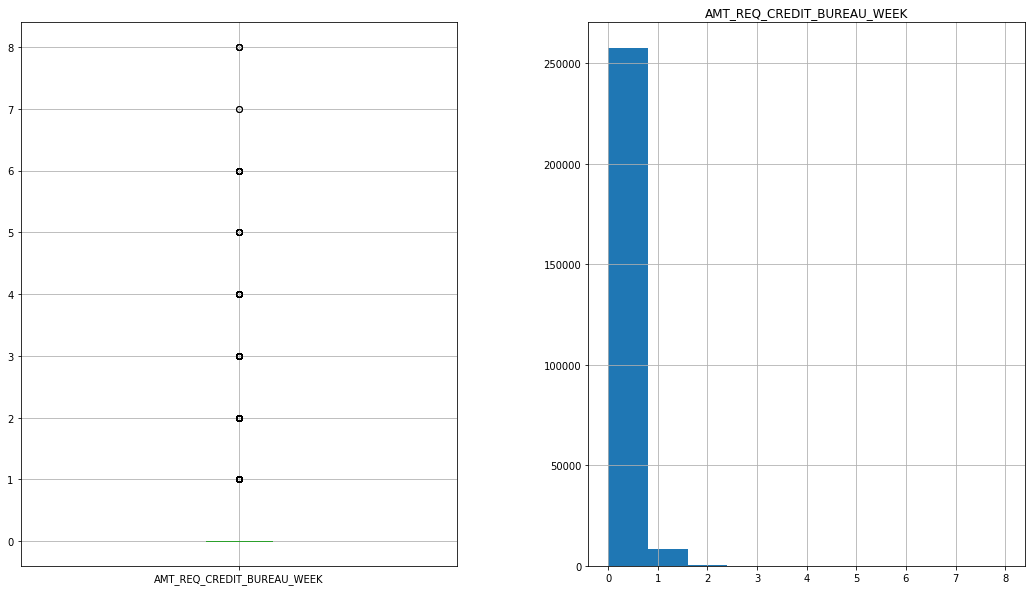

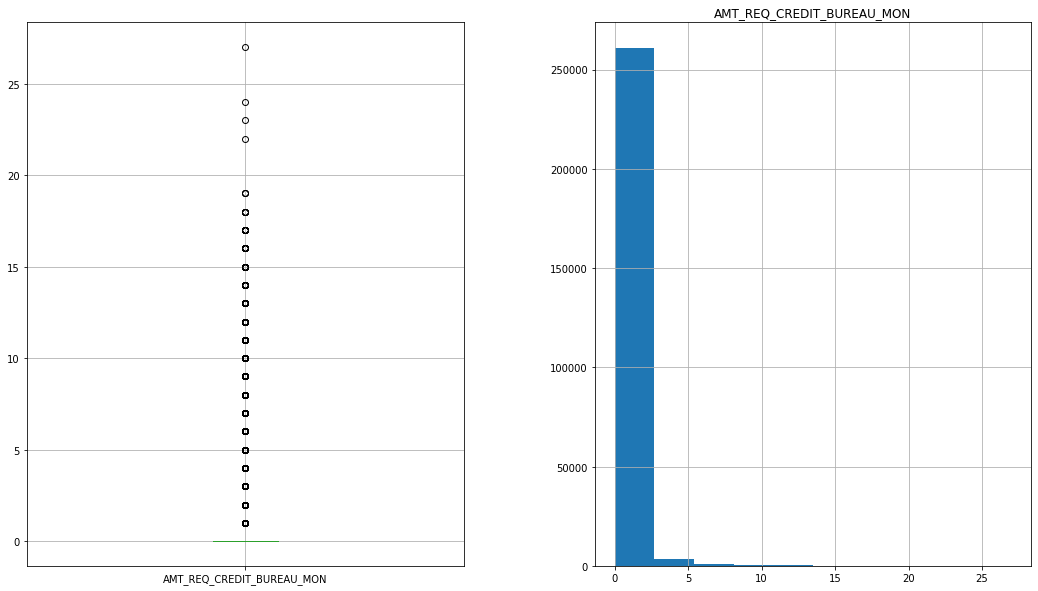

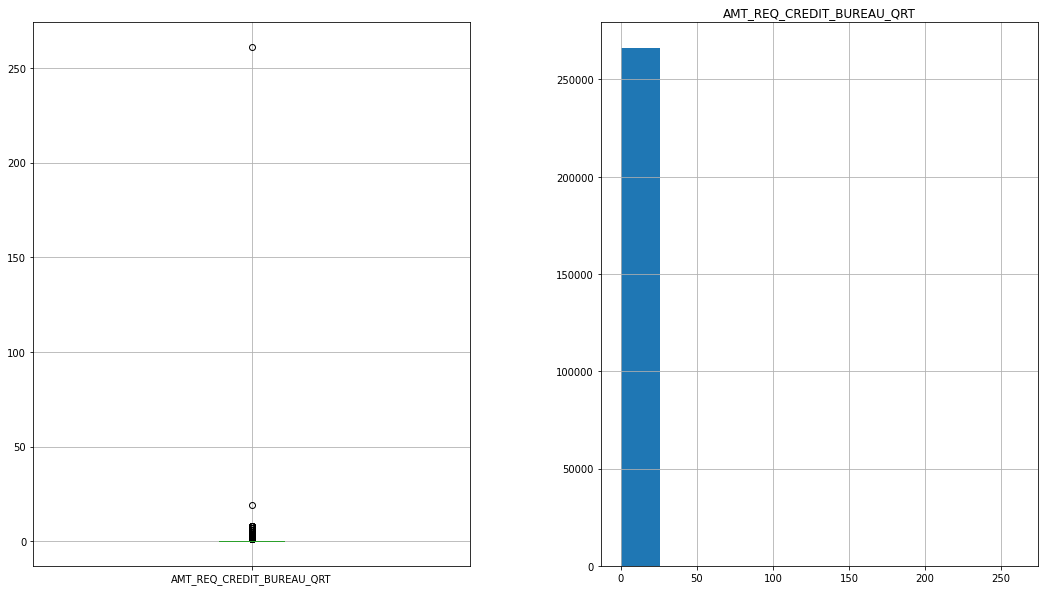

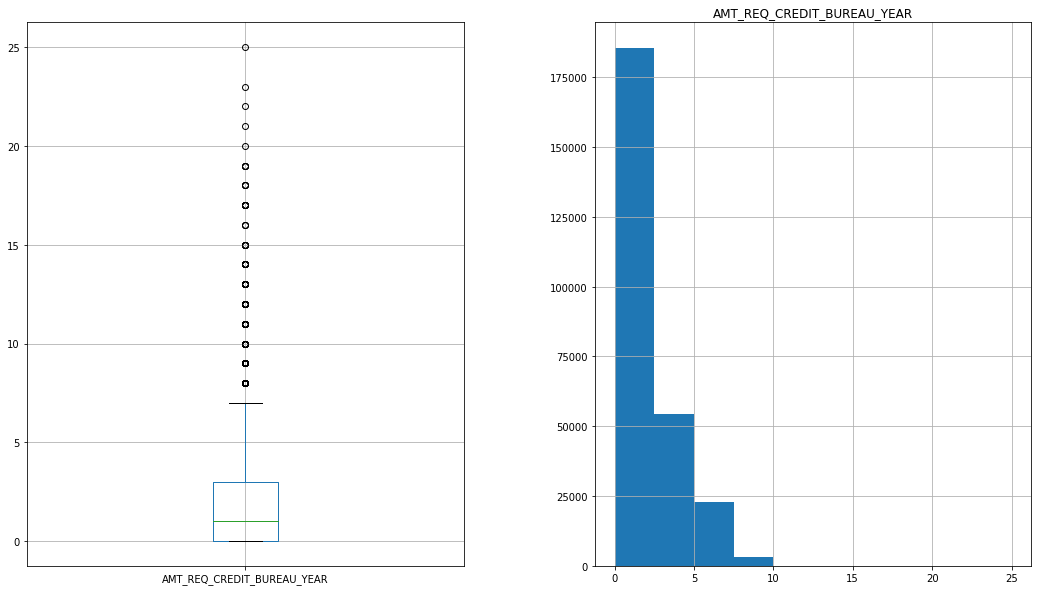

In [114]:
for col in numeric_columns:
    fig = plt.figure(figsize = (18, 10))
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)
    app_train.boxplot(column = col, ax = ax1)
    app_train.hist(column = col, ax = ax2)
    plt.show();

### 從上面的圖檢查的結果，至少這三個欄位好像有點可疑

+ AMT_INCOME_TOTAL: 客戶收入
+ REGION_POPULATION_RELATIVE: 客戶居住地區的標準化人口（數字越大意味著客戶居住的地區人口越多
+ OBS_60_CNT_SOCIAL_CIRCLE: 對客戶的社交環境進行多少次觀察，可觀察到 60 DPD（逾期天數）默認值

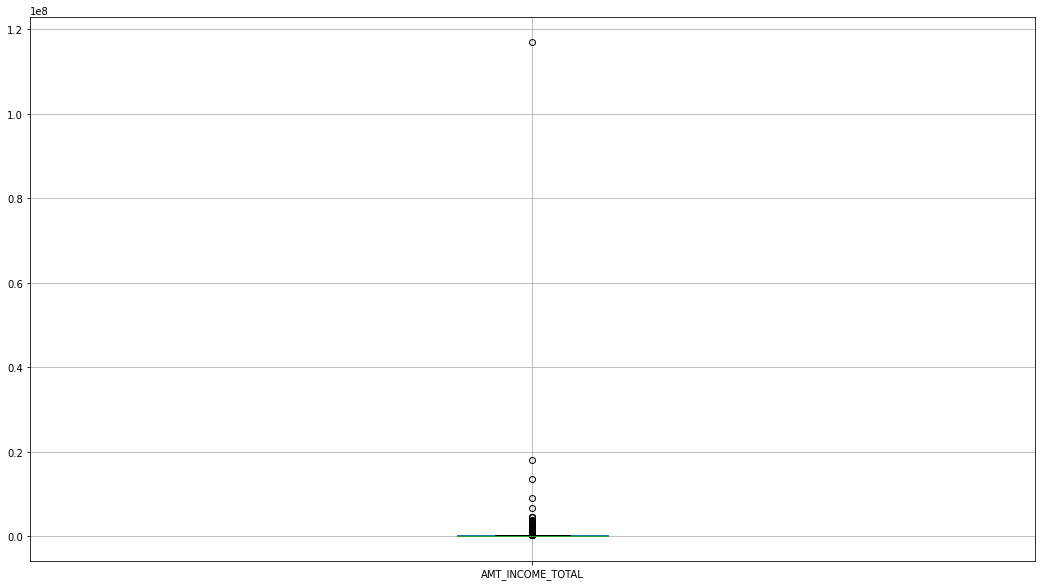

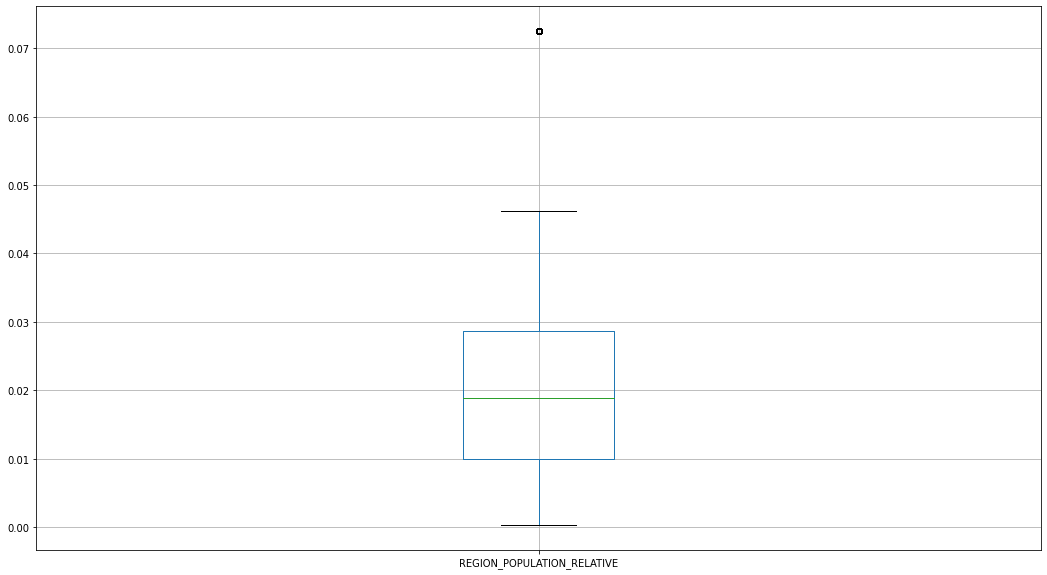

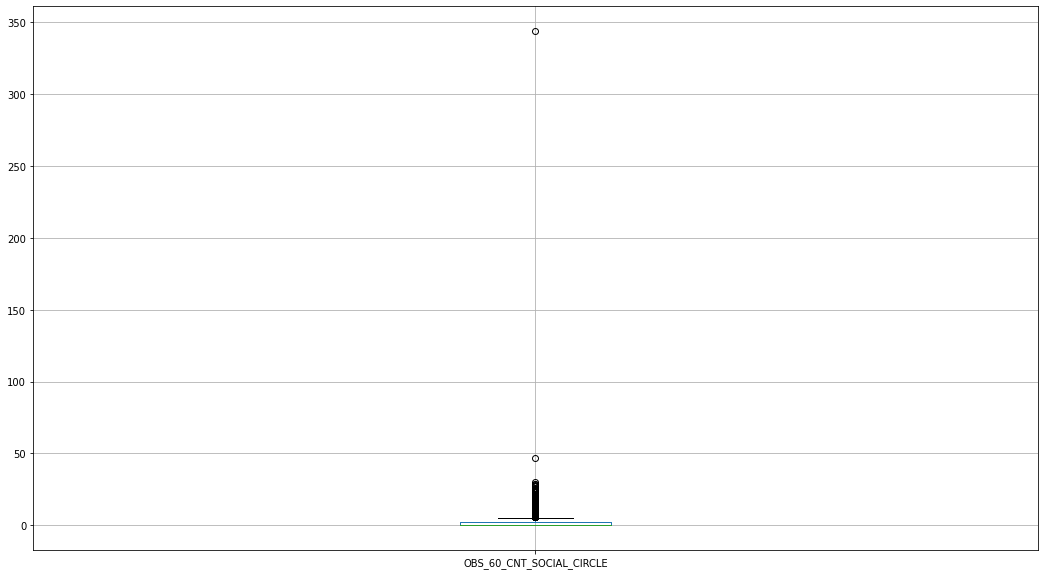

In [115]:
## 針對這三個特徵來檢視
for c in ['AMT_INCOME_TOTAL', 'REGION_POPULATION_RELATIVE', 'OBS_60_CNT_SOCIAL_CIRCLE']:
    fig = plt.figure(figsize = (18, 10))
    app_train.boxplot(column = c)
    plt.show();

### Hints: Emprical Cumulative Density Plot, [ECDF](https://zh.wikipedia.org/wiki/%E7%BB%8F%E9%AA%8C%E5%88%86%E5%B8%83%E5%87%BD%E6%95%B0), [ECDF with Python](https://stackoverflow.com/questions/14006520/ecdf-in-python-without-step-function)

### 經建累積分布函數圖 ECDF (Empirical Cumulative Distribution Function)

每個數據點在所有數據的佔比

### 補充: https://medium.com/ai%E5%8F%8D%E6%96%97%E5%9F%8E/exploratory-data-analysis-%E6%8E%A2%E7%B4%A2%E8%B3%87%E6%96%99-ecdf-7fa350c32897 

#### 'AMT_INCOME_TOTAL'問題: 最大值離平均與中位數很遠

In [116]:
## # 最大值離平均與中位數很遠
app_train['AMT_INCOME_TOTAL'].describe()

count    3.075110e+05
mean     1.687979e+05
std      2.371231e+05
min      2.565000e+04
25%      1.125000e+05
50%      1.471500e+05
75%      2.025000e+05
max      1.170000e+08
Name: AMT_INCOME_TOTAL, dtype: float64

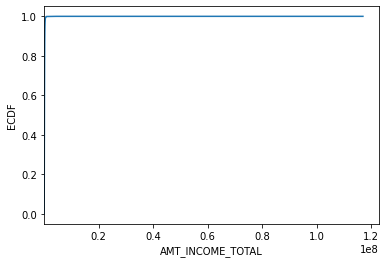

In [122]:
## 繪製經驗分布
## sort_index: 根據index排序
## cumsum(): 累加總數
cdf = app_train['AMT_INCOME_TOTAL'].value_counts().sort_index().cumsum()

plt.plot(list(cdf.index), cdf/cdf.max())
plt.xlabel('AMT_INCOME_TOTAL')
plt.ylabel('ECDF')
## 限制x軸和y軸範圍
plt.xlim(cdf.index.min(), cdf.index.max() * 1.05)
plt.ylim([-0.05, 1.05])

plt.show();

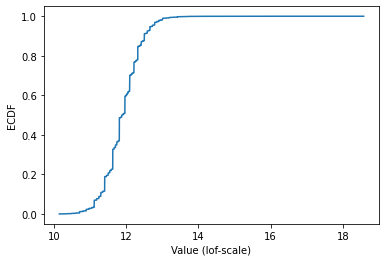

In [123]:
## 更好的檢視圖形 - 改變y軸的scale(對x軸進行轉換), 讓我們可以正常檢視ECDF
plt.plot(np.log(list(cdf.index)), cdf / cdf.max())
plt.xlabel('Value (lof-scale)')
plt.ylabel('ECDF')
plt.ylim([-0.05, 1.05])
plt.show();


## 補充：Normal dist 的 ECDF
![ecdf_normal](https://au.mathworks.com/help/examples/stats/win64/PlotEmpiricalCdfAndCompareWithSamplingDistributionExample_01.png)

#### 'REGION_POPULATION_RELATIVE'問題: 最大值落在分布之外

In [124]:
app_train['REGION_POPULATION_RELATIVE'].describe()

count    307511.000000
mean          0.020868
std           0.013831
min           0.000290
25%           0.010006
50%           0.018850
75%           0.028663
max           0.072508
Name: REGION_POPULATION_RELATIVE, dtype: float64

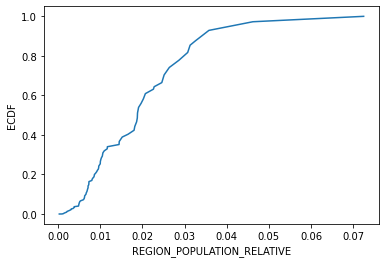

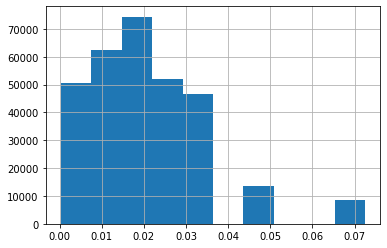

0.000290        2
0.000533       39
0.000938       28
0.001276      558
0.001333      235
            ...  
0.031329    11321
0.032561     6636
0.035792    16408
0.046220    13442
0.072508     8412
Name: REGION_POPULATION_RELATIVE, Length: 81, dtype: int64

In [125]:
## 繪製 Empirical Cumulative Density Plot (ECDF)

cdf = app_train['REGION_POPULATION_RELATIVE'].value_counts().sort_index().cumsum()

plt.plot(list(cdf.index), cdf / cdf.max())
plt.xlabel('REGION_POPULATION_RELATIVE')
plt.ylabel('ECDF')
plt.ylim([-0.05, 1.05])
plt.show();

app_train['REGION_POPULATION_RELATIVE'].hist()
plt.show()

app_train['REGION_POPULATION_RELATIVE'].value_counts().sort_index()

# 就以這個欄位來說，雖然有資料掉在分布以外，也不算異常，僅代表這間公司在稍微熱鬧的地區有的據點較少，
# 導致 region population relative 在少的部分較為密集，但在大的部分較為疏漏

### 'OBS_60_CNT_SOCIAL_CIRCLE'問題: 最大值落在分布之外

In [126]:
app_train['OBS_60_CNT_SOCIAL_CIRCLE'].describe()

count    306490.000000
mean          1.405292
std           2.379803
min           0.000000
25%           0.000000
50%           0.000000
75%           2.000000
max         344.000000
Name: OBS_60_CNT_SOCIAL_CIRCLE, dtype: float64

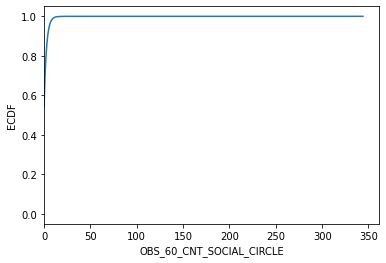

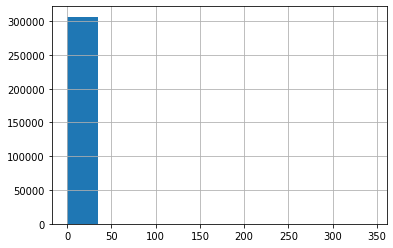

In [127]:
## 繪製 Empirical Cumulative Density Plot (ECDF)

cdf = app_train['OBS_60_CNT_SOCIAL_CIRCLE'].value_counts().sort_index().cumsum()

plt.plot(list(cdf.index), cdf / cdf.max())
plt.xlabel('OBS_60_CNT_SOCIAL_CIRCLE')
plt.ylabel('ECDF')
plt.xlim(cdf.index.min() * 0.95, cdf.index.max() * 1.05)
plt.ylim([-0.05, 1.05])
plt.show()

app_train['OBS_60_CNT_SOCIAL_CIRCLE'].hist()
plt.show()

## 注意：當 histogram 畫出上面這種圖 (只出現一條，但是 x 軸延伸很長導致右邊有一大片空白時，代表右邊有值但是數量稀少。這時可以考慮用 value_counts 去找到這些數值

In [128]:
app_train['OBS_60_CNT_SOCIAL_CIRCLE'].value_counts().sort_index(ascending = False)

344.0         1
47.0          1
30.0          1
29.0          2
28.0          1
27.0          5
26.0          1
25.0         11
24.0         12
23.0         13
22.0         20
21.0         28
20.0         30
19.0         44
18.0         49
17.0         73
16.0        137
15.0        166
14.0        238
13.0        401
12.0        620
11.0        837
10.0       1335
9.0        1959
8.0        2886
7.0        4344
6.0        6349
5.0        9463
4.0       13946
3.0       20215
2.0       29766
1.0       48870
0.0      164666
Name: OBS_60_CNT_SOCIAL_CIRCLE, dtype: int64

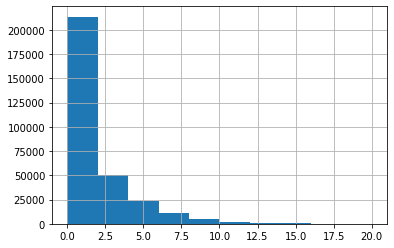

In [129]:
# 把一些極端值暫時去掉，在繪製一次 Histogram
# 選擇 OBS_60_CNT_SOCIAL_CIRCLE 小於 20 的資料點繪製
"""
Your Code Here
"""
loc_a = app_train['OBS_60_CNT_SOCIAL_CIRCLE'] <= 20
loc_b = 'OBS_60_CNT_SOCIAL_CIRCLE'

app_train.loc[loc_a, loc_b].hist()
plt.show()